
## Importing libraries

First, we load all the necessary libraries. We mainly use `numpy`, `pandas`, `matplotlib` for data manipulation and `scipy` for numerical operations and fitting.



In [1]:
import os
import io
import requests
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

from bs4 import BeautifulSoup

from scipy.signal import lfilter
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import curve_fit


## Custom warning types

We use custom exception and warning classes to distinguish database problems, non-physical data, and suspicious signals from common Python errors.



In [2]:
import warnings
class BrokenGolemDatabaseWarning(RuntimeWarning):
    '''When some important files are missing or suspicious.'''
    pass
class DataAccessWarning(RuntimeWarning):
    '''Warning when data files in Golem database are not accessible.'''
    pass
class SuspiciousDataWarning(RuntimeWarning):
    '''Warning when data are suspicious, e.g. non-finite values, non-numeric values'''
    pass
class DataAccessError(Exception):
    '''When data missing on Golem database'''
    def __init__(self, name=None):
        if name is not None:
            message = f'Data {name} not accessible on Golem database. Load function returned None.'
        else:
            message = f'Data not accessible on Golem database. Load function returned None.'
        super().__init__(message)

## Disable Matplotlib warnings
 Disable warnings that appear when you have too many figure windows open at once.

In [3]:
plt.rcParams.update({'figure.max_open_warning': 0})


## Definition of SENTINEL object

_SENTINEL is used to distinguish function calls with default values ​​of function parameters.



In [4]:
# initial function variable
_SENTINEL = object()

## Input parameters

In [5]:
# =============================================================================
# Recent shots (vacuum-plasma pairs)
# =============================================================================
# He-discharge without stabilization
# shot_no_vacuum = 50772
# shot_no = 50771

# H-discharge without both stabilizations
# shot_no_vacuum = 50817
# shot_no = 50816
# shot_no = 51079

# H-discharge with position stabilization
# shot_no_vacuum = 51073
# shot_no = 51072

# H-discharge with both stabilizations
# shot_no_vacuum = 51071
# shot_no = 51070

# =============================================================================
# Godsfavour's shots (all without current stabilization)
# =============================================================================
# without position stabilization (that in Godsfavour's thesis)
shot_no_vacuum = 45264
shot_no = 45261

# without position stabilization
# shot_no_vacuum = 45274
# shot_no = 45276

# with position stabilization
# shot_no_vacuum = 45264
# shot_no = 45265

## Figure saving settings

In [6]:
# show figures?
showFig = True

# save figures?
saveFig = False

# figure save format
saveFormat = 'png'


## Tokamak GOLEM parameters



In [7]:
# radii of GOLEM tokamak in meters
a_Gt = 0.085
R_Gt = 0.4


## DAS parameters



In [8]:
# sampling period in seconds
T_SAMPLE: float = 10**(-6)


## URL addresses of data files on the GOLEM database.



In [9]:
# system parameters (calibraton constants etc.)
URL_SYSTEM_PARAMETERS: str = 'http://golem.fjfi.cvut.cz/shotdir/49092/Production/Parameters/SystemParameters/{name}'
# requested discharge parameters
URL_REQUEST_PARAMETERS: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Operation/Discharge/{name}'
# stabilisation
URL_POSITION_STAB: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Infrastructure/PositionStabilization/Parameters/main_switch'
URL_CURRENT_STAB: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Infrastructure/CurrentStabilization/Parameters/main_switch'
# plasma presence
URL_B_PLASMA: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/Results/b_plasma'
# plasma position
URL_R: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/FastCameras/Camera_Radial/CameraRadialPosition'
# plasma time parameters
URL_T_START: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/Results/t_plasma_start'
URL_T_END: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/Results/t_plasma_end'
# basic diagnostics
URL_BT: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/BasicDiagnostics/Results/Bt.csv'
URL_Bt_coil: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/U_BtCoil.csv'
URL_IP: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/BasicDiagnostics/Results/Ip.csv'
URL_Uloop: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/U_Loop.csv'
# Mirnov coils
URL_OLDMIRNOV = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/MHDring-TM/{name}.csv'
URL_MIRNOV1: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Devices/DASs/2NI_PC-VoSv/NI.lvm'
URL_MIRNOV2: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/MHDring-TM/DAS_raw_data_dir/rawData.csv'
# Rogowski coils
URL_ROGOWSKI_OUTER: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/PlasmaDetection/U_RogCoil.csv'
URL_ROGOWSKI_OLD_INNER: str = 'http://golem.fjfi.cvut.cz/shotdir/{shot_no}/Diagnostics/MHDring-TM/U_rogowski.csv'
# old diamagnetic loops
URL_DIAMAGNET_OLD_INNER: str = 'http://golem.fjfi.cvut.cz/shotdir/{shot_no}/Diagnostics/MHDring-TM/U_diam_inner.csv'
URL_DIAMAGNET_OLD_OUTER: str = 'http://golem.fjfi.cvut.cz/shotdir/{shot_no}/Diagnostics/MHDring-TM/U_diam_outer.csv'
# old toroidal Mirnov coils
URL_TOR_MIRNOV_LFS_OLD: str = 'http://golem.fjfi.cvut.cz/shotdir/{shot_no}/Diagnostics/MHDring-TM/U_Bt_LFS.csv'
URL_TOR_MIRNOV_HFS_OLD: str = 'http://golem.fjfi.cvut.cz/shotdir/{shot_no}/Diagnostics/MHDring-TM/U_Bt_HFS.csv'
# probes
URL_DoubleLangBallPenProbe: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/DoubleLangBallPenProbe/Parameters/r_lp_tip'
URL_DoubleRakeProbe: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/DoubleRakeProbe/Parameters/r_first_tip'
# stabilization waveform
URL_POSITION_STAB_WAVEFORM: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Infrastructure/PositionStabilization/Parameters/{name}'
URL_CURRENT_STAB_WAVEFORM: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Infrastructure/CurrentStabilization/Parameters/waveform'
# osciloscopes
URL_TektrMSO64: str = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Devices/Oscilloscopes/TektrMSO64-a/TektrMSO64_ALL.csv'

## Helper functions for safe data reading from GOLEM database
These functions ensure safe data loading from the GOLEM database without the analysis code crashing in the event of corrupted or missing data.

In [10]:
# save check for check_request_parameters
def safe_check(func, shot, **kwargs):
    '''Safe wrapper for checking parameters without crashing if parameters are missing.'''
    try:
        return func(shot_no=shot, **kwargs)
    except Exception as e:
        warnings.warn(f"Error for shot {shot}, param \'{kwargs.get('name', func.__name__)}\': {e}", DataAccessWarning, stacklevel=3)
        return np.nan
    
    
# find out connected diagnostics
def find_connected_diagnostics_in_url(shot_no: int, url: str, print_info: bool=True) -> str | None:
    '''Checks connected diagnostics in oscilloscope/pc belonging to folder with url html link in Golem Database.'''
    # get html page of Tektronix MSO64 folder
    url_folder = url.format(shot_no=shot_no)
    r = requests.get(url_folder)
    r.raise_for_status()
    
    # parsing links
    soup = BeautifulSoup(r.text, 'html.parser')
    links = [a['href'] for a in soup.find_all('a') if a['href'].endswith('.SETUP')]
    if len(links) != 1:
        warnings.warn('Only one .SETUP file was expected, instead it was found: ' + str(links), BrokenGolemDatabaseWarning, stacklevel=2)
        return None
    setup_file_url = url_folder + links[0]
    
    # download the contents of the SETUP file
    r2 = requests.get(setup_file_url)
    r2.raise_for_status()
    content_text = r2.text
    
    # find out which diagnostics are connected
    m = re.search(r"\*\*(.*?)\*\*", content_text)
    if m:
        diagnostics = m.group(1)
        if print_info:
            print(f'Diagnostic: {diagnostics} in the Tektronix MSO64 oscilloscope.')
        
    return diagnostics


# read csv file safely
def safe_read_csv(url, *, sep=',', decimal='.', names=None, length:  int | None = None, dt: float, breakScript: bool=False):
    '''
    Reads csv file safely for the implemented algorithm.
    Return NaN DataFrame if data are not accessible and breakScript False (good for for-cycles of shots)
    '''
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        if "<html" in r.text.lower():
            if not breakScript:
                warnings.warn('***WARNING*** HTML response instead of CSV', DataAccessWarning, stacklevel=2)
            else:
                raise DataAccessError('HTML response instead of CSV')
        return pd.read_csv(io.StringIO(r.text), sep=sep, decimal=decimal, names=names, low_memory=False)
    except Exception as e:
        if not breakScript:
            warnings.warn(f'***WARNING*** Failed to load {url}: {e}', DataAccessWarning, stacklevel=2)
            return nan_dataframe(names=names, length=length, dt=dt)
        else:
            raise DataAccessError('Failed to load {url}: {e}')
            
            
# build pd.DataFrame (with columns defined by list[str]) full of NaN
def nan_dataframe(names: list[str], length: int = 35000, dt: float = 1e-6) -> pd.DataFrame:
    '''
    Builds DataFrame full of NaN. If the first column is time ('t','T','time','Time'),
    the first column will be a time axis of length `length` with step `dt`. Other columns NaN.
    
    parameters
        – names: list of column names
        – length: number of rows (default 35000)
        – dt: time step (sampling period) in seconds (default 1e-6)
    
    return: pd.DataFrame
    '''
    # make DataFrame with columns called by names list
    data = pd.DataFrame(columns=names)
    
    # fill whole DataFrame with NaN
    data = data.reindex(range(length))
    
    # make first column time scale with sampling frequency 10^6 Hz if first column is time
    if names[0].lower() in ['t', 'time']:
        data[names[0]] = np.arange(length) * dt
    
    return data


## Data loading functions


Definition of function that checks plasma presence during particular shot.

In [11]:

# checks plasma presence
def check_plasma_presence(shot_no: int) -> bool:
    # data path
    content = requests.get(URL_B_PLASMA.format(shot_no=shot_no)).content
    # reads data
    b_plasma = pd.read_csv(io.StringIO(content.decode('iso-8859-1')), names = ['b_plasma'])
    # checking plasma presence
    if b_plasma['b_plasma'][0] == 1:
        return True
    else:
        return False

Definition of function that reads the time values of plasma endpoints.

In [ ]:

# loads plasma time parameters
def get_plasma_time_parameters(shot_no: int):
    # data path for t_start
    content = requests.get(URL_T_START.format(shot_no=shot_no)).content
    # reads t_start
    t_start = pd.read_csv(io.StringIO(content.decode('iso-8859-1')), names = ['t_start'])
    t_start = t_start.iloc[0, 0]
    # data path for t_end
    content = requests.get(URL_T_END.format(shot_no=shot_no)).content
    # reads t_end
    t_end = pd.read_csv(io.StringIO(content.decode('iso-8859-1')), names = ['t_end'])
    t_end = t_end.iloc[0, 0]
    
    # return time in s
    t_start *= 1e-3
    t_end *= 1e-3
    
    return t_start, t_end

Definition of function that reads system parameter values, e.g. chamber resistance.

In [13]:

# load system parameter (calibration constant etc.)
def get_system_parameter(shot_no: int, name: str) -> float:
    # data path
    content = requests.get(URL_SYSTEM_PARAMETERS.format(shot_no=shot_no, name=name)).content
    # reads data
    value = pd.read_csv(io.StringIO(content.decode('iso-8859-1')), names = [f'{name}'])
    return value[f'{name}'].iat[0]

Definition of function that reads signal from flux loop of the ferromagnetic transformer core, i.e. U_loop.

In [14]:

# loads U_loop data (from basic diagnostics)
def get_U_loop_data(shot_no: int) -> pd.DataFrame:
    # data path
    req = requests.get(URL_Uloop.format(shot_no=shot_no))
    if req.status_code != 200 or '<html' in req.text.lower():
        warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req.status_code})', DataAccessWarning, stacklevel=2)
        return None
    # reads data
    raw_data = pd.read_csv(io.StringIO(req.content.decode('iso-8859-1')), sep = ',', decimal = '.', names = ['t', 'U_loop'])
    
    return raw_data

Definition of function that reads signal from Rogowski coil wrapped around the vacuum vessel (later called outer Rogowski coil) and measures the sum of the plasma and chamber currents.

In [15]:

# loads integrated Ip data from outer Rogowski coil (from basic diagnostics)
def get_Ip_data(shot_no: int) -> pd.DataFrame:
    # check shot if vacuum
    shot_is_vacuum = not safe_check(check_plasma_presence, shot=shot_no)
    if not shot_is_vacuum:
        # data path
        req = requests.get(URL_IP.format(shot_no=shot_no))
        if req.status_code != 200 or '<html' in req.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req.status_code})', DataAccessWarning, stacklevel=2)
            return None
        # reads data
        data = pd.read_csv(io.StringIO(req.content.decode('iso-8859-1')), sep = ',', decimal='.', names = ['t', 'Ip'], dtype={'t': float, 'Ip': float}, na_values=['', 'NaN', 'n/a', '---'])
        # conversion to SI base units
        data['t'] *= 1e-3
        data['Ip'] *= 1e3
    else:
        # make 0 current for vacuum shot
        U_loop = get_U_loop_data(shot_no=shot_no)
        data = pd.DataFrame({'t': U_loop['t'], 'Ip': np.zeros(len(U_loop['t']))})
    
    return data

Definition of function that reads signal from coil placed outside the vacuum vessel and measuring local toroidal magnetic field. The signal is already integrated and calibrated to the tokamak axis R_0 (major radius).

In [16]:

# loads integrated Bt data from outer TF coil (from basic diagnostics)
def get_Bt_data(shot_no: int) -> pd.DataFrame:
    # data path
    req = requests.get(URL_BT.format(shot_no=shot_no))
    if req.status_code != 200 or '<html' in req.text.lower():
        warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req.status_code})', DataAccessWarning, stacklevel=2)
        return None
    # reads data
    data = pd.read_csv(io.StringIO(req.content.decode('iso-8859-1')), sep = ',', names = ['t', 'Bt'])
    # conversion to SI base units
    data['t'] *= 1e-3
    
    return data

Definition of function that reads signal from all coils on MHD ring, i.e. poloidal and toroidal Mirnov coils, diamagnetic loops, inner Rogowski coil, and from outer Rogowski coil, and from limiter Mirnov coils.

In [17]:
# loads data from MHD ring
def get_MHD_ring_data(shot_no: int) -> pd.DataFrame:
    # check shot if vacuum
    shot_is_vacuum = not safe_check(check_plasma_presence, shot=shot_no)
    
    # data path and reads data
    if shot_no <= 45000:
        dfs = {}
        time_col = None
        names = [f'ring_{i}' for i in range(1,17)] + ['U_rogowski', 'U_diam_inner', 'U_diam_outer', 'U_Bt_HFS', 'U_Bt_LFS']
        for name in names:
            req = requests.get(URL_OLDMIRNOV.format(shot_no=shot_no, name=name))
            if req.status_code != 200 or '<html' in req.text.lower():
                warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req.status_code})', DataAccessWarning, stacklevel=2)
                return None
            df = pd.read_csv(io.StringIO(req.content.decode('iso-8859-1')), sep = ',', decimal = '.', names = ['t', name])
            if time_col is None:
                time_col = df['t']
            dfs[name] = df[name]
        
        req2 = requests.get(URL_ROGOWSKI_OUTER.format(shot_no=shot_no))
        if req2.status_code != 200 or '<html' in req2.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req2.status_code})', DataAccessWarning, stacklevel=2)
            return None
        raw_data_outer_RogCoil = pd.read_csv(io.StringIO(req2.content.decode('iso-8859-1')), sep=',', decimal='.', names = ['t', 'rogowski'])
        
        # repair broken data
        raw_data_outer_RogCoil = repair_broken_data(data=raw_data_outer_RogCoil, name='OuterRogowskiCoil')
        
        # interpolate data to match sampling time of Mirnov coils        
        interpolated_outer_RogCoil = np.interp(time_col, raw_data_outer_RogCoil['t'], raw_data_outer_RogCoil['rogowski'])

        raw_data = pd.DataFrame({'t': time_col, **{f'f{i}': dfs[f'ring_{i}'] for i in range(1,17)}, 'rogowski1': dfs['U_rogowski'], 'rogowski2': interpolated_outer_RogCoil, 'diamagnet1': dfs['U_diam_inner'], 'diamagnet2': dfs['U_diam_outer'], 'tor1': dfs['U_Bt_LFS'], 'tor2': dfs['U_Bt_HFS']})
    
    elif shot_no > 45000 and shot_no < 47680:
        # Mirnov coils
        req = requests.get(URL_MIRNOV1.format(shot_no=shot_no))
        if req.status_code != 200 or '<html' in req.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req.status_code})', DataAccessWarning, stacklevel=2)
            return None
        pol_mirnov = pd.read_csv(io.StringIO(req.content.decode('iso-8859-1')), sep = '\t', decimal = ',', header=0, low_memory=False, skiprows=1)#TODO
        
        pol_mirnov.columns = ['t', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16']
        
        # diamagnetic loops
        req1 = requests.get(URL_DIAMAGNET_OLD_INNER.format(shot_no=shot_no))
        if req1.status_code != 200 or '<html' in req1.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req1.status_code})', DataAccessWarning, stacklevel=2)
            return None
        raw_data_inner_diamagnet = pd.read_csv(io.StringIO(req1.content.decode('iso-8859-1')), sep = ',', decimal = '.', names = ['t', 'diamagnet'])
        
        req2 = requests.get(URL_DIAMAGNET_OLD_OUTER.format(shot_no=shot_no))
        if req2.status_code != 200 or '<html' in req2.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req2.status_code})', DataAccessWarning, stacklevel=2)
            return None
        raw_data_outer_diamagnet = pd.read_csv(io.StringIO(req2.content.decode('iso-8859-1')), sep=',', decimal='.', names = ['t', 'diamagnet'])
        
        # Rogowski coils
        req3 = requests.get(URL_ROGOWSKI_OLD_INNER.format(shot_no=shot_no))
        if req3.status_code != 200 or '<html' in req3.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req3.status_code})', DataAccessWarning, stacklevel=2)
            return None
        raw_data_inner_RogCoil = pd.read_csv(io.StringIO(req3.content.decode('iso-8859-1')), sep = ',', decimal = '.', names = ['t', 'rogowski'])
        
        if not shot_is_vacuum:
            req4 = requests.get(URL_ROGOWSKI_OUTER.format(shot_no=shot_no))
            if req4.status_code != 200 or '<html' in req4.text.lower():
                warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req4.status_code})', DataAccessWarning, stacklevel=2)
                return None
            raw_data_outer_RogCoil = pd.read_csv(io.StringIO(req4.content.decode('iso-8859-1')), sep = ',', decimal = '.', names = ['t', 'rogowski'])

            # repair broken data
            raw_data_outer_RogCoil = repair_broken_data(data=raw_data_outer_RogCoil, name='OuterRogowskiCoil')
           
            # interpolate data to match sampling time of Mirnov coils
            interpolated_outer_RogCoil = np.interp(pol_mirnov['t'], raw_data_outer_RogCoil['t'], raw_data_outer_RogCoil['rogowski'])
        else:
            interpolated_outer_RogCoil = np.full_like(pol_mirnov['t'], np.nan, dtype=float)
        
        # toroidal Mirnov coils
        req5 = requests.get(URL_TOR_MIRNOV_LFS_OLD.format(shot_no=shot_no))
        if req5.status_code != 200 or '<html' in req5.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req5.status_code})', DataAccessWarning, stacklevel=2)
            return None
        raw_data_tor_LFS = pd.read_csv(io.StringIO(req5.content.decode('iso-8859-1')), sep = ',', decimal = '.', names = ['t', 'U'])
        
        req6 = requests.get(URL_TOR_MIRNOV_HFS_OLD.format(shot_no=shot_no))
        if req6.status_code != 200 or '<html' in req6.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req6.status_code})', DataAccessWarning, stacklevel=2)
            return None
        raw_data_tor_HFS = pd.read_csv(io.StringIO(req6.content.decode('iso-8859-1')), sep = ',', decimal = '.', names = ['t', 'U'])
        
        # limiter Mirnov coils
        # TODO
        
        # U_loop
        req11 = requests.get(URL_TOR_MIRNOV_HFS_OLD.format(shot_no=shot_no))
        if req11.status_code != 200 or '<html' in req11.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req11.status_code})', DataAccessWarning, stacklevel=2)
            return None
        raw_data_U_loop = pd.read_csv(io.StringIO(req11.content.decode('iso-8859-1')), sep = ',', decimal = '.', names = ['t', 'U'])
        
        # missing channels (lim1, none1 etc.)
        missing_signal = np.full_like(pol_mirnov['t'], np.nan, dtype=float)
        
        # repair broken data
        raw_data_inner_diamagnet = repair_broken_data(data=raw_data_inner_diamagnet, name='InnerDiamagnet')
        raw_data_outer_diamagnet = repair_broken_data(data=raw_data_outer_diamagnet, name='OuterDiamagnet')
        raw_data_inner_RogCoil = repair_broken_data(data=raw_data_inner_RogCoil, name='InnerRogowskiCoil')
        raw_data_tor_LFS = repair_broken_data(data=raw_data_tor_LFS, name='toroidal LFS')
        raw_data_tor_HFS = repair_broken_data(data=raw_data_tor_HFS, name='toroidal HFS')
        raw_data_U_loop = repair_broken_data(data=raw_data_U_loop, name='U_loop')
        
        # interpolate data to match sampling time of Mirnov coils
        interpolated_inner_diamagnet = np.interp(pol_mirnov['t'], raw_data_inner_diamagnet['t'], raw_data_inner_diamagnet['diamagnet'])
        interpolated_outer_diamagnet = np.interp(pol_mirnov['t'], raw_data_outer_diamagnet['t'], raw_data_outer_diamagnet['diamagnet'])
        interpolated_inner_RogCoil = np.interp(pol_mirnov['t'], raw_data_inner_RogCoil['t'], raw_data_inner_RogCoil['rogowski'])
        interpolated_tor_LFS = np.interp(pol_mirnov['t'], raw_data_tor_LFS['t'], raw_data_tor_LFS['U'])
        interpolated_tor_HFS = np.interp(pol_mirnov['t'], raw_data_tor_HFS['t'], raw_data_tor_HFS['U'])
        interpolated_U_loop = np.interp(pol_mirnov['t'], raw_data_U_loop['t'], raw_data_U_loop['U'])
        
        # make pandas.DataFrame of both signals
        raw_data = pd.DataFrame({'t': pol_mirnov['t'], **{f'f{i}': pol_mirnov[f'f{i}'] for i in range(1, 17)}, **{f'lim{i}': missing_signal for i in range(1, 5)}, 'diamagnet1': interpolated_inner_diamagnet, 'diamagnet2': interpolated_outer_diamagnet, 'rogowski1': interpolated_inner_RogCoil, 'rogowski2': interpolated_outer_RogCoil, 'tor1': interpolated_tor_LFS, 'tor2': interpolated_tor_HFS, **{f'none{i}': missing_signal for i in range(1,7)}, 'U_loop': interpolated_U_loop})
    
    elif (shot_no >= 47680) and (shot_no <= 50296):
        data = safe_read_csv(URL_MIRNOV2.format(shot_no=shot_no), sep=',', decimal='.', names=['t', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'diamagnet1', 'diamagnet2', 'rogowski', 'tor1', 'tor2'], length=35000, dt=T_SAMPLE)
        print('data:',data)
        if not shot_is_vacuum:
            req2 = requests.get(URL_ROGOWSKI_OUTER.format(shot_no=shot_no))
            if req2.status_code != 200 or '<html' in req2.text.lower():
                warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req2.status_code})', DataAccessWarning, stacklevel=2)
                return None
            raw_data_outer_RogCoil = pd.read_csv(io.StringIO(req2.content.decode('iso-8859-1')), sep=',', decimal='.', names = ['t', 'rogowski'])
            print('out rog:', raw_data_outer_RogCoil)
            # repair broken data
            raw_data_outer_RogCoil = repair_broken_data(data=raw_data_outer_RogCoil, name='OuterRogowskiCoil')
            
            # interpolate data to match sampling time of Mirnov coils        
            interpolated_outer_RogCoil = np.interp(data['t'], raw_data_outer_RogCoil['t'], raw_data_outer_RogCoil['rogowski'])
        else:
            interpolated_outer_RogCoil = np.full_like(data['t'], np.nan, dtype=float)
            
        # make pandas.DataFrame   
        raw_data = pd.DataFrame({'t': data['t'], **{f'f{i}': data[f'f{i}'] for i in range(1, 17)}, **{f'diamagnet{i}': data[f'diamagnet{i}'] for i in range(1,3)}, 'rogowski1': data['rogowski'], 'rogowski2': interpolated_outer_RogCoil, **{f'tor{i}': data[f'tor{i}'] for i in range(1, 3)}})
    
    elif (shot_no >= 50296) and (shot_no <= 50605):
        data = safe_read_csv(URL_MIRNOV2.format(shot_no=shot_no), sep=',', decimal='.', names=['t', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'lim1', 'lim2', 'lim3', 'lim4', 'none1', 'none2', 'none3', 'none4', 'U_loop', 'rogowski', 'tor1', 'tor2', 'diamagnet1', 'diamagnet2'], length=35000, dt=T_SAMPLE)
        
        if not shot_is_vacuum:
            req2 = requests.get(URL_ROGOWSKI_OUTER.format(shot_no=shot_no))
            if req2.status_code != 200 or '<html' in req2.text.lower():
                warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req2.status_code})', DataAccessWarning, stacklevel=2)
                return None
            raw_data_outer_RogCoil = pd.read_csv(io.StringIO(req2.content.decode('iso-8859-1')), sep=',', decimal='.', names = ['t', 'rogowski'])
        
            # repair broken data
            raw_data_outer_RogCoil = repair_broken_data(data=raw_data_outer_RogCoil, name='OuterRogowskiCoil')
           
            # interpolate data to match sampling time of Mirnov coils        
            interpolated_outer_RogCoil = np.interp(data['t'], raw_data_outer_RogCoil['t'], raw_data_outer_RogCoil['rogowski'])
        else:
            interpolated_outer_RogCoil = np.full_like(data['t'], np.nan, dtype=float)
            
        # make pandas.DataFrame   
        raw_data = pd.DataFrame({'t': data['t'], **{f'f{i}': data[f'f{i}'] for i in range(1, 17)}, **{f'lim{i}': data[f'lim{i}'] for i in range(1,5)}, **{f'diamagnet{i}': data[f'diamagnet{i}'] for i in range(1,3)}, 'rogowski1': data['rogowski'], 'rogowski2': interpolated_outer_RogCoil, **{f'tor{i}': data[f'tor{i}'] for i in range(1, 3)}, **{f'none{i}': data[f'none{i}'] for i in range(1,5)}, 'U_loop': data['U_loop']})
    elif 51069 <= shot_no <= 51079:#TODO
        # data = safe_read_csv(URL_MIRNOV2.format(shot_no=shot_no), sep=',', decimal='.', names=['t', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'lim1', 'lim2', 'lim3', 'lim4', 'none1', 'none2', 'none3', 'none4', 'U_loop', 'rogowski', 'tor1', 'tor2', 'diamagnet1', 'diamagnet2', 'none5', 'none6'], length=35000, dt=T_SAMPLE)
        data = pd.read_csv(f"rawData{shot_no}.csv", sep=',', decimal='.', names=['t', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'lim1', 'lim2', 'lim3', 'lim4', 'none1', 'none2', 'none3', 'none4', 'U_loop', 'rogowski', 'tor1', 'tor2', 'diamagnet1', 'diamagnet2', 'none5', 'none6'], skiprows=1)
        
        req2 = requests.get(URL_ROGOWSKI_OUTER.format(shot_no=shot_no))
        if req2.status_code != 200 or '<html' in req2.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req2.status_code})', DataAccessWarning, stacklevel=2)
            raw_data_outer_RogCoil = nan_dataframe(names=['t', 'rogowski'], length=len(data['t'])).fillna(0)
        else:
            raw_data_outer_RogCoil = pd.read_csv(io.StringIO(req2.content.decode('iso-8859-1')), sep=',', decimal='.', names = ['t', 'rogowski'])
        
        # repair broken data
        raw_data_outer_RogCoil = repair_broken_data(data=raw_data_outer_RogCoil, name='OuterRogowskiCoil')
        
        # interpolate data to match sampling time of Mirnov coils        
        interpolated_outer_RogCoil = np.interp(data['t'], raw_data_outer_RogCoil['t'], raw_data_outer_RogCoil['rogowski'])
    
        # make pandas.DataFrame   
        raw_data = pd.DataFrame({'t': data['t'], **{f'f{i}': data[f'f{i}'] for i in range(1, 17)}, **{f'lim{i}': data[f'lim{i}'] for i in range(1,5)}, **{f'diamagnet{i}': data[f'diamagnet{i}'] for i in range(1,3)}, 'rogowski1': data['rogowski'], 'rogowski2': interpolated_outer_RogCoil, **{f'tor{i}': data[f'tor{i}'] for i in range(1, 3)}, **{f'none{i}': data[f'none{i}'] for i in range(1,7)}, 'U_loop': data['U_loop']})
    else:
        data = safe_read_csv(URL_MIRNOV2.format(shot_no=shot_no), sep=',', decimal='.', names=['t', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'lim1', 'lim2', 'lim3', 'lim4', 'none1', 'none2', 'none3', 'none4', 'U_loop', 'rogowski', 'tor1', 'tor2', 'diamagnet1', 'diamagnet2', 'none5', 'none6'], length=40000, dt=T_SAMPLE)
        
        req2 = requests.get(URL_ROGOWSKI_OUTER.format(shot_no=shot_no))
        if req2.status_code != 200 or '<html' in req2.text.lower():
            warnings.warn(f'***WARNING*** Data for #{shot_no} are not accessible (HTTP {req2.status_code})', DataAccessWarning, stacklevel=2)
            raw_data_outer_RogCoil = nan_dataframe(names=['t', 'rogowski'], length=40000, dt=T_SAMPLE).fillna(0)
        else:
            raw_data_outer_RogCoil = pd.read_csv(io.StringIO(req2.content.decode('iso-8859-1')), sep=',', decimal='.', names = ['t', 'rogowski'])

        # repair broken data
        raw_data_outer_RogCoil = repair_broken_data(data=raw_data_outer_RogCoil, name='OuterRogowskiCoil')
       
        # interpolate data to match sampling time of Mirnov coils        
        interpolated_outer_RogCoil = np.interp(data['t'], raw_data_outer_RogCoil['t'], raw_data_outer_RogCoil['rogowski'])
    
        # make pandas.DataFrame   
        raw_data = pd.DataFrame({'t': data['t'], **{f'f{i}': data[f'f{i}'] for i in range(1, 17)}, **{f'lim{i}': data[f'lim{i}'] for i in range(1,5)}, **{f'diamagnet{i}': data[f'diamagnet{i}'] for i in range(1,3)}, 'rogowski1': data['rogowski'], 'rogowski2': interpolated_outer_RogCoil, **{f'tor{i}': data[f'tor{i}'] for i in range(1, 3)}, **{f'none{i}': data[f'none{i}'] for i in range(1,7)}, 'U_loop': data['U_loop']})
    
    # rewrite non-physical values with NaN
    raw_data = raw_data.apply(pd.to_numeric, errors='coerce')
 
    # some coils on MHD ring have flipped polarity
    if shot_no < 46688:  
        raw_data['f10'] *= -1
        raw_data['f11'] *= -1
        raw_data['f12'] *= -1
        raw_data['f14'] *= -1
        raw_data['f16'] *= -1    
    else:
        raw_data['f1'] *= -1
        raw_data['f9'] *= -1
        raw_data['f13'] *= -1
    
    # load data from Tektronix MSO64 if diamagnetic diagnostics measured there
    diagnostics_in_Tektr = find_connected_diagnostics_in_url(shot_no=shot_no, url='http://golem.fjfi.cvut.cz/shots/{shot_no}/Devices/Oscilloscopes/TektrMSO64-a/', print_info=False)
    if diagnostics_in_Tektr == 'Diamagnetism':
        # channels in oscilloscope
        if 50245 <= shot_no <= 50260:
            format_names = ['t', 'dia in', 'dia out', 'rog in', 'Bt HFS']
        elif 50261 <= shot_no < 50299:
            format_names = ['t', 'rog in', 'dia in', 'dia out', 'Bt HFS', 'none1', 't_int', 'rog int']
        elif 50770 <= shot_no <= 50774:
            format_names = ['t', 'none1', 'none2', 'none3', 'rog in']
        elif 50775 <= shot_no <= 50803:
            format_names = ['t', 'none1', 'none2', 'rog in', 'none3']
        elif shot_no == 50804:
            format_names = ['t', 'none1', 'none2', 'dia in', 'dia out']
        elif 50805 <= shot_no <= 50807:
            format_names = ['t', 'rog in', 'Bt HFS', 'dia in', 'dia out']
        elif shot_no == 50808:
            format_names = ['t', 'rog in', 'dia out', 'dia in', 'Bt HFS']
        elif 50809 <= shot_no <= 50827 or 51069 <= shot_no <= 51079:
            format_names = ['t', 'dia in', 'dia out', 'rog in', 'Bt HFS']
        else:
            format_names = ['t', 'ch1', 'ch2', 'ch3', 'ch4'] #TODO user has to label the channels
            
        if format_names is not None:
            raw_data_Tektr = get_TektrMSO64_data(shot_no=shot_no, names=format_names)
            
            # rewrite non-physical values with NaN
            raw_data_Tektr = raw_data_Tektr.apply(pd.to_numeric, errors='coerce')
        else:
            raw_data_Tektr = None
    elif shot_no in [50770, 50771, 50772]:
        '''Exception – diamagnetism data was measured but saved as DoubleBallPenProbe'''
        # channels in oscilloscope
        if 50770 <= shot_no <= 50774:
            format_names = ['t', 'none1', 'none2', 'none3', 'rog in']
        else:
            format_names = None  # no Tektronix
        
        if format_names is not None:
            raw_data_Tektr = get_TektrMSO64_data(shot_no=shot_no, names=format_names)

            # rewrite non-physical values with NaN
            raw_data_Tektr = raw_data_Tektr.apply(pd.to_numeric, errors='coerce')
        else:
            raw_data_Tektr = None
    else:
        raw_data_Tektr = None
    
    # swap the measured channels on Tektronix oscilloscope with missing channels in MHD ring
    if raw_data_Tektr is not None:
        mapping = {'diamagnet1': 'dia in', 'diamagnet2': 'dia out', 'rogowski1': 'rog in', 'tor1': 'Bt LFS', 'tor2': 'Bt HFS'}
        
        # find min/max time
        t_min = min(raw_data['t'].min(), raw_data_Tektr['t'].min())
        t_max = max(raw_data['t'].max(), raw_data_Tektr['t'].max())
    
        # compute the smallest sampling time
        dt_raw = np.diff(raw_data['t']).min()
        dt_tektr = np.diff(raw_data_Tektr['t']).min()
        dt = min(dt_raw, dt_tektr)
    
        # make new common time
        common_time = np.arange(t_min, t_max + dt, dt)
    
        # make new DataFrame with common time scale
        raw_data_interp = pd.DataFrame({'t': common_time})
        raw_data_Tektr_interp = pd.DataFrame({'t': common_time})
    
        # interpolate MHD ring data
        for col in raw_data.columns:
            if col != 't':
                raw_data_interp[col] = np.interp(common_time, raw_data['t'], raw_data[col])
    
        # interpolate Tektronix data
        for col in raw_data_Tektr.columns:
            if col != 't':
                raw_data_Tektr_interp[col] = np.interp(common_time, raw_data_Tektr['t'], raw_data_Tektr[col])
    
        # swap channels according to mapping
        for dst, src in mapping.items():
            if src in raw_data_Tektr_interp.columns:
                raw_data_interp[dst] = raw_data_Tektr_interp[src]
        
        # rewrite original DataFrame
        raw_data = raw_data_interp
        
    # rewrite non-physical values with NaN
    raw_data = raw_data.apply(pd.to_numeric, errors='coerce')
    
    return raw_data

Definition of function that reads only Mirnov coils signal from MHD ring.

In [18]:
# loads data from mirnov coils
def get_mirnov_data(shot_no: int) -> pd.DataFrame:
    
    data = get_MHD_ring_data(shot_no=shot_no)
    raw_data = pd.DataFrame({'t': data['t'], **{f'f{i}': data[f'f{i}'] for i in range(1,17)}, **{f'lim{i}': data[f'lim{i}'] for i in range(1,5)}, **{f'tor{i}': data[f'tor{i}'] for i in range(1, 3)}})
    
    return raw_data

Definition of function that reads only diamagnetic loops signal from MHD ring.

In [19]:
# loads data from diamagnetic coils
def get_diamagnet_data(shot_no: int) -> pd.DataFrame:
    
    data = get_MHD_ring_data(shot_no=shot_no)
    raw_data = pd.DataFrame({'t': data['t'], **{f'diamagnet{i}': data[f'diamagnet{i}'] for i in range(1,3)}})

    return raw_data

Definition of function that reads only diamagnetic loops signal from MHD ring.

In [20]:
# loads data from Rogowski coil
def get_rogowski_data(shot_no: int) -> pd.DataFrame:
    
    data = get_MHD_ring_data(shot_no=shot_no)
    raw_data = pd.DataFrame({'t': data['t'], **{f'rogowski{i}': data[f'rogowski{i}'] for i in range(1,3)}})

    return raw_data

Definition of function that reads signal from Tektronix MSO64 oscilloscope.

In [21]:

# loads data from Tektronix oscilloscope
def get_TektrMSO64_data(shot_no: int, names: list[str]=_SENTINEL, method: str='MHD ring') -> pd.DataFrame | None:
    # names
    if names is _SENTINEL:
        names = ['t', 'ch1', 'ch2', 'ch3', 'ch4']
    
    # for old script if data measured in Tektronix
    if method == 'Tektronix':
        # channels in oscilloscope
        if 50245 <= shot_no <= 50260:
            names = ['t', 'dia in', 'dia out', 'rog in', 'Bt HFS']
        elif 50261 <= shot_no < 50299:
            names = ['t', 'rog in', 'dia in', 'dia out', 'Bt HFS', 'none1', 't_int', 'rog int']
        elif 50770 <= shot_no <= 50774:
            names = ['t', 'none1', 'none2', 'none3', 'rog in']
        elif 50775 <= shot_no <= 50803:
            names = ['t', 'none1', 'none2', 'rog in', 'none3']
        elif shot_no == 50804:
            names = ['t', 'none1', 'none2', 'dia in', 'dia out']
        elif 50805 <= shot_no <= 50807:
            names = ['t', 'rog in', 'Bt HFS', 'dia in', 'dia out']
        elif shot_no == 50808:
            names = ['t', 'rog in', 'dia out', 'dia in', 'Bt HFS']
        elif 50809 <= shot_no <= 50827 or 51069 <= shot_no <= 51079:
            names = ['t', 'dia in', 'dia out', 'rog in', 'Bt HFS']
        else:
            return None  # no Tektronix
    # load data
    try:
        content = requests.get(URL_TektrMSO64.format(shot_no=shot_no)).content
        raw_data = pd.read_csv(io.StringIO(content.decode('iso-8859-1')), skiprows=12, sep=',', decimal='.', names=names)
    except Exception as e:
        warnings.warn(f'Tektronix CSV not available for shot {shot_no}. Error: {e}', DataAccessWarning, stacklevel=2)
        raw_data = None
        
    # write in metadata about diagnostics connected into oscilloscope
    diagnostics = find_connected_diagnostics_in_url(shot_no=shot_no, url='http://golem.fjfi.cvut.cz/shots/{shot_no}/Devices/Oscilloscopes/TektrMSO64-a/', print_info=False)
    raw_data.attrs['measured diagnostics'] = diagnostics
    
    return raw_data


## Helper functions for repairing data

These functions address basic data hygiene:
- removing duplicate time points
- replacing NaN/inf values
- interpolating short outages
- making notes about these changes in metadata

The goal is to ensure that subsequent integration and numerical operations are stable.



In [22]:
# checks if signal includes non-finite values and changes them to NaN, remove duplicated data points
def check_broken_data(data: pd.DataFrame | pd.Series, name: str = 'data'):
    '''
    Checks if signal includes duplicated data points in time and removes duplicates.
    Checks if signal includes non-finite values and changes them to NaN.
    Than write warnings in console and also makes warning notes in metadata.
    '''
    # if input is Series, it is converted to DataFrame with one column
    is_series = isinstance(data, pd.Series)
    if is_series:
        data = data.to_frame('signal')
    else:
        data = data.copy()
        
    time = data.index if is_series else data['t']
        
    # remove duplicated time points (row-wise)
    mask = ~time.duplicated()
    data = data.loc[mask].sort_index()

    # rewrite all non-finite values (infs etc.) to NaNs
    for col in data.columns:
        # sig = data[col]
        # sig.loc[~np.isfinite(sig)] = np.nan
        # data[col] = sig
        # rewrite all non-finite values to NaN
        data[col] = data[col].where(np.isfinite(data[col]), np.nan)
        
        # check for broken data
        bad = np.isnan(data[col])
        # warning about broken data
        if np.any(bad):
            bad_idx = np.where(bad)[0]
            # check gap lengths
            gap_lengths = lengths_of_consecutive_true(bad)
            # write warning
            if bad.sum() <= 5:
                warnings.warn(f'Channel {col} in {name} contains {bad.sum()} non-finite samples at indices {bad_idx[:5]}.', SuspiciousDataWarning, stacklevel=2)
            else:
                warnings.warn(f'Channel {col} in {name} contains {bad.sum()} non-finite samples of gap lengths {gap_lengths}.', SuspiciousDataWarning, stacklevel=2)
            # add warning in metadata
            data.attrs[f'{col}_glitch_indices'] = bad_idx.tolist()
            data.attrs[f'{col}_glitch_count'] = int(bad.sum())
            data.attrs[f'{col}_gap_lengths'] = gap_lengths
        
    # if input was Series, return Series
    if is_series:
        series = data.iloc[:, 0]
        series.attrs = data.attrs.copy()
        return series
        
    return data


# rewrites non-physical values (infs, NaNs)
def repair_broken_data(data: pd.DataFrame | pd.Series, name: str='data', max_gap: int=5, interpolate: bool=True):
    '''
    If check_broken_data() was not called:
        Checks if signal includes duplicated data points in time and removes duplicates.
        Checks if signal includes non-finite values and changes them to NaN.
        Than write warnings in console and also makes warning notes in metadata.
    
    Rewrite non-physical values (infs, NaNs, etc.) in data points to either interpolated (if interpolate==True – default option) value or to 0 (if interpolate==False).
    '''
    # change pd.Series to pd.DataFrame of two columns
    is_series = isinstance(data, pd.Series)
    if is_series:
        data = data.to_frame('signal')
    else:
        data = data.copy()
        
    time = data.index if is_series else data['t']
        
    # remove duplicated time points (row-wise)
    mask = ~time.duplicated()
    data = data.loc[mask].sort_index()

    for col in data.columns:
        # sig = data[col].copy()
        # sig.loc[~np.isfinite(sig)] = np.nan
        # rewrite all non-finite values to NaN
        data[col] = data[col].where(np.isfinite(data[col]), np.nan)

        # find NaNs in data
        bad = np.isnan(data[col])
        
        # lengths of gaps (regions of NaNs) and their indexes
        try:
            bad_idx_all = data.attrs[f'{col}_glitch_indices']
            gap_lengths = data.attrs[f'{col}_gap_lengths']
        except KeyError:
            gap_lengths = lengths_of_consecutive_true(bad)
            bad_idx_all = np.where(bad)[0]

            # warning about NaNs
            if bad.sum() > 0:
                data.attrs[f'{col}_glitch_indices'] = bad_idx_all.tolist()
                data.attrs[f'{col}_glitch_count'] = int(bad.sum())
                data.attrs[f'{col}_gap_lengths'] = gap_lengths
                warnings.warn(f'Channel {col} in {name} has {bad.sum()} non-finite samples of gap lengths {gap_lengths}.', SuspiciousDataWarning, stacklevel=2)

        # mask for short gaps
        interpolate_mask = np.zeros_like(data[col], dtype=bool)
        start = 0
        for length in gap_lengths:
            idx_block = bad_idx_all[start:start+length]
            if length <= max_gap:
                interpolate_mask[idx_block] = True
            start += length

        # indexes for interpolation
        bad_idx = np.where(interpolate_mask)[0]
        good_idx = np.where(~bad)[0]
        good_vals = data[col].iloc[good_idx].to_numpy()  # integer-based array pro np.interp

        if bad_idx.size > 0:
            # add end points if NaN at start or at end
            if bad_idx[0] == 0:
                good_idx = np.insert(good_idx, 0, 0)
                good_vals = np.insert(good_vals, 0, 0.0)
            if bad_idx[-1] == len(data[col]) - 1:
                good_idx = np.append(good_idx, len(data[col]) - 1)
                good_vals = np.append(good_vals, 0.0)

            # interpolation
            if interpolate and good_idx.size > 1:
                data[col].iloc[bad_idx] = np.interp(bad_idx, good_idx, good_vals)
            elif not interpolate:
                data[col].iloc[bad_idx] = 0.0

    # return pd.Series if input was pd.Series
    if is_series:
        s = data.iloc[:, 0]
        s.attrs = data.attrs.copy()
        return s
    
    return data


# count lenths of consecutive True blocks in boolean mask
def lengths_of_consecutive_true(mask: np.ndarray) -> list[int]:
    '''
    Returns lengths of consecutive True blocks in boolean mask.
    '''
    # if mask is empty
    if len(mask) == 0:
        return []
    # otherwise count lengths of consecutive True-blocks
    lengths = []
    count = 0
    for val in mask:
        if val:
            count += 1
        elif count > 0:
            lengths.append(count)
            count = 0
    if count > 0:
        lengths.append(count)
        
    return lengths

## Helper functions for working with data

These functions address:
- correcting polarity of coils/signals
- removing DC offset
- smoothing signal

In [23]:
# checks polarity of signal and makes it preferably positive changing also polarity of raw signal to stay coherent
def correct_polarity(data: pd.Series, change_data: pd.Series | list[pd.Series] | None=None):
    '''
    Finds polarity of signal (diagnostic) and makes max(abs(signal)) be always positive.
    Use only for signal proportional to measured physical quantity or for integrated signal proportional to derivative of measured physical quantity (raw signal put in raw_data variable to stay coherent in that case!).
    
    Correct polarity is necessary for correct addition and subtraction of two signals!
    '''
    # filter data points with finite values
    finite = data[np.isfinite(data)]
    if finite.empty or finite.abs().max() == 0:
        warnings.warn("Data samples are all zero or invalid – polarity unchanged", SuspiciousDataWarning, stacklevel=2)
        if change_data is not None:
            return data, change_data
        else:
            return data

    # multiply signal by sign of its maximum value
    sign = np.sign(finite.loc[finite.abs().idxmax()])
    data *= sign
    # set polarity of raw signal to be same as polarity of integrated signal
    if change_data is not None:
        if isinstance(change_data, pd.Series):
            change_data *= sign
        else:
            for data in change_data:
                data *= sign
    if change_data is not None:
        return data, change_data
    else:
        return data


# removes constant DC offset from signal
def remove_offset(data: pd.DataFrame, fallback_n: int = 100) -> pd.DataFrame:
    ''' 
    Subtracts DC offset computed from negative-time pre-trigger region.
    If no negative-time data are available, use first `fallback_n` samples
    and issue a warning.
    '''
    data = data.copy()
    # boolean mask for pre-trigger region
    mask = data['t'] <= 0
    if not mask.any():
        warnings.warn(f'No negative-time (pre-trigger) data available for offset computation. Using first {fallback_n} samples instead.', SuspiciousDataWarning, stacklevel=2)
        mask = data.index < fallback_n
        
    for col in [c for c in data.columns if c != 't']:
        offset = data.loc[mask, col].mean()
        data[col] -= offset
        
    return data


# smooths data
def weighted_moving_average(x, N):
    '''Smoothens the input signal x, with Hanning window of length N.'''
    w = np.hanning(N)
    w /= w.sum()
    return np.convolve(x, w, mode='same')


## Functions for RLC model fit of damped oscillations

In many plasma diagnostics (e.g. Rogowski coils, magnetic probes), the measured signals contain **damped oscillations** caused by the response of the measurement circuit, primary circuit of tokamak or surrounding electronics. These oscillations can often be well described by the solution of a **series RLC circuit** in the **underdamped regime**.

The current in such a system follows:


$I(t) = A \, e^{-\alpha t} \sin(\omega t)$,


where:
- $A$ is the oscillation amplitude,
- $\alpha$ is the damping coefficient (related to resistance),
- $\omega$ is the angular oscillation frequency.

This form corresponds to the solution of the homogeneous RLC equation:

$L\frac{d^2 I}{dt^2} + R \frac{dI}{dt} + \frac{1}{C} I = 0$.


---

### Model Implementation

In the code, the RLC response is implemented as:

```python
def RLC_model(t, a1, a2, a3):
    return a1 * np.exp(-a2 * t) * np.sin(a3 * t)


The RLC_fit() function fits the RLC model to selected time regions of the signal and subtracts the fitted oscillatory component in order to remove circuit-induced oscillations from the data.

In [24]:

# builds RLC model
def RLC_model(t, a1, a2, a3):
    return a1 * np.exp(-a2 * t) * np.sin(a3 * t)

In [25]:

# fits data with RLC model
def RLC_fit(t: np.ndarray | pd.Series, I: np.ndarray | pd.Series, name: str, shot_no: int, t_start: float | list[float] | None=None, t_end: float | list[float] | None=None, initial_guess: list[float]=[0, 2, 30], correct_pol: bool=False, showFig: bool=True, saveFig: bool=False, saveFormat: str='png', legend_loc: str='lower right'):
    '''
    Fit RLC model to specified regions of signal.
    
    Parameters:
        – t : np.ndarray or pd.Series = time axis of the signal.
        – I : np.ndarray or pd.Series = signal to fit (e.g. Rogowski coil data).
        – name : str = name of the diagnostics, used for graph title and for name of the saved figure if saveFig True.
        – shot_no : int = number of shot in Golem database
        – t_start : float or list of float = start time(s) of fit region(s). Can be a single float or list.
        – t_end : float or list of float = end time(s) of fit region(s). Must be same length as t_start if list.
        – initial_guess : list of 3 floats = initial guess for curve_fit parameters [a1, a2, a3].
        – correct_pol : bool = if plot I_corrected with corrected (positive) polarity of signal
    
    Returns:
        – params : np.ndarray = fitted parameters [a1, a2, a3].
        – I_fit : np.ndarray = fitted curve over full time axis `t`.
    '''
    # plasma time parameters
    plasma_start, plasma_end = get_plasma_time_parameters(shot_no=shot_no)

    # default: fit whole time axis
    if t_start is None:
        t_start = [t.min()]
    if t_end is None:
        t_end = [t.max()]
        
    # ensure t_start and t_end are lists
    if isinstance(t_start, (float, int)):
        t_start = [t_start]
    if isinstance(t_end, (float, int)):
        t_end = [t_end]
    if len(t_start) != len(t_end):
        warnings.warn('t_start and t_end must have the same length.', SuspiciousDataWarning, stacklevel=2)
        return None

    # build mask for all regions to fit
    mask = np.zeros_like(t, dtype=bool)
    for ts, te in zip(t_start, t_end):
        mask |= (t >= ts) & (t <= te)

    # select data points in fit regions
    t_fit_data = t[mask]
    I_fit_data = I[mask]

    if len(t_fit_data) == 0:
        warnings.warn('No valid data points in specified fit regions.', SuspiciousDataWarning, stacklevel=2)
        return None

    # perform fit
    params, covariance = curve_fit(RLC_model, t_fit_data, I_fit_data, p0=initial_guess, maxfev=10000)

    # compute fitted curve over entire time axis
    I_fit = RLC_model(t, *params)
    
    # remove fiited data from input signal
    I_corrected = I.copy()
    I_corrected -= I_fit
    if correct_pol:
        I_corrected_plot = correct_polarity(data=I_corrected)
    else:
        I_corrected_plot = I_corrected.copy()
        
    # plot result
    plt.figure(figsize=(10, 6))
    plt.plot(t_fit_data*1e3, I_fit_data*1e-3, label='fitted', color='skyblue', marker='o', linestyle='')
    plt.plot(t*1e3, I*1e-3, label='signal', color=(0.061, 0.234, 0.853))
    plt.plot(t*1e3, I_fit*1e-3, label=f'fit: $I = {params[0]:.3f}\  exp(-{params[1]:.3f}\, t) \ \sin({params[2]:.3f}\,t)$', color='red', linestyle='--')
    plt.plot(t*1e3, I_corrected_plot*1e-3, label='corrected', color='green')
    if plasma_start > 0 and plasma_end > 0:
        plt.axvline(x=plasma_start*1e3, color='black', linestyle='--', linewidth=1) # show duration of plasma
        plt.axvline(x=plasma_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('time (ms)')
    plt.ylabel('I (kA)')
    plt.title(f'#{shot_no}')
    plt.legend(loc=f'{legend_loc}')
    plt.grid(True)
    if saveFig:
        s_fixed = name.replace(' ', '_')
        plt.savefig(f'results/{shot_no}_RLC_fit_{s_fixed}.{saveFormat}')
    if showFig:
        plt.show()

    return I_corrected, I_fit, params

## Rogowski Coil Signal Analysis

This section implements the full processing pipeline for **Rogowski coil diagnostics**, used to measure the plasma current in tokamak discharges. The analysis converts raw voltage signals into calibrated plasma current waveforms and removes several systematic contributions such as offsets, chamber currents, and magnetic cross-talk.

---

### Physical Background

A Rogowski coil measures the time derivative of the current flowing through the conductor enclosed by the coil:

$\frac{dI}{dt} \propto U(t)$,

where U(t) is the induced voltage. The plasma current is therefore obtained by **time integration** of the measured voltage signal followed by multiplication with a calibration constant. In practice, the raw signal also contains:

- DC offsets and baseline drift,
- chamber (vessel) currents,
- cross-talk from the toroidal magnetic field coils,
- electronic ringing and parasitic oscillations.

These effects must be removed before the signal can be interpreted as the plasma current.

---

### Main Processing Pipeline (`rogowski_coil_analysis()`)

The main function performs the following steps:

1. **Data loading**  
   Raw Rogowski coil voltages and loop voltage signals are loaded from the database for a selected shot.

2. **Data validation and offset removal**  
   Non-physical or missing values are detected and repaired. DC offsets are removed from both Rogowski and loop voltage signals to ensure stable numerical integration.

3. **Signal integration**  
   The corrected voltage signals are integrated in time using the trapezoidal rule and multiplied by calibration constants to obtain current signals from both inner and outer Rogowski coils.

4. **Polarity correction**  
   Signal polarity is corrected to ensure a consistent sign convention for the plasma current.

5. **Chamber current subtraction**  
   The current induced in the vacuum vessel is estimated from the loop voltage using the vessel resistance and subtracted from the outer Rogowski coil signal.

6. **Removal of Bt cross-talk**  
   Parasitic oscillations caused by toroidal field coil coupling are removed by fitting and subtracting a damped RLC model from both Rogowski signals.

7. **Visualization**  
   The function plots:
   - raw Rogowski voltages,
   - integrated currents,
   - corrected plasma current signals after all subtractions.

The function returns the final plasma current signal and the repaired raw voltage data.

---

### Output

The main analysis function returns:

- `Ip` — processed plasma current signals from inner and outer Rogowski coils,
- `raw_data_repaired` — cleaned raw voltage data suitable for further processing or diagnostics validation.

This pipeline provides a robust reconstruction of the plasma current suitable for quantitative analysis and cross-diagnostic comparison.


In [26]:
def rogowski_coil_analysis(shot_no: int, showFig: bool=True, saveFig: bool=False, saveFormat: str='png') -> pd.DataFrame:     
    '''
    This is the main function of Rogowski coils data analysis.
    Rogowski_coil_analysis() 
        – plots raw signal
        – integrate signal and plots it
        – subtracts Bt cross-talk to get Ip
        
    shot_no = number of shot in Golem database
    showFig = parameter if figures should be shown
    saveFig = parameter if figures should be saved
    saveFormat = format of saved figures, default = png
    '''
    print('...ROGOWSKI COIL ANALYSIS...')
    # make folder
    if saveFig:
        os.makedirs('results', exist_ok=True)
    
    print('Loading data...')
    # load data
    t_start, t_end = get_plasma_time_parameters(shot_no=shot_no)
    raw_data = get_rogowski_data(shot_no=shot_no)
    U_loop = get_U_loop_data(shot_no=shot_no)
    
    # check if data are non-physical
    raw_data_checked = check_broken_data(data=raw_data, name='raw_data')
    U_loop_checked = check_broken_data(data=U_loop, name='U_loop')
    
    # remove offset from raw signal
    raw_data_detrended = remove_offset(data=raw_data_checked)
    U_loop_detrended = remove_offset(data=U_loop_checked)

    # repair broken (non-finite) data points for safe integration
    raw_data_repaired = repair_broken_data(data=raw_data_detrended, name='raw_data_detrended')
    U_loop_repaired = repair_broken_data(data=U_loop_detrended, name='U_loop_detrended')
    
    # integrate raw signal and plot integrated data
    print('Integration...')
    integrated_data = integrate_signal(shot_no=shot_no, raw_data=raw_data_repaired)
    
    # correct polarity
    raw_data_corrected = raw_data_repaired.copy()
    integrated_data_corrected = integrated_data.copy()
    integrated_data_corrected['rogowski1'] = correct_polarity(data=integrated_data['rogowski1'])
    integrated_data_corrected['rogowski2'], raw_data_corrected['rogowski2'] = correct_polarity(data=integrated_data['rogowski2'], change_data=raw_data_repaired['rogowski2'])
    

    # remove chamber current from outer Rogowski
    Ip = integrated_data_corrected.copy()
    print('Subtraction of chamber current...')
    Ip, I_ch = remove_I_chamber(shot_no=shot_no, Ip=Ip, U_loop=U_loop_repaired)
    
    # remove Bt cross-talk from inner Rogowski
    print('Removing Bt cross-talk...')
    Ip['rogowski1'], I_fit, params = RLC_fit(t=Ip['t'], I=Ip['rogowski1'], name='inner Rogowski', shot_no=shot_no, t_start=[0.0005, t_end+0.002], t_end=[t_start-0.0005, Ip['t'].iloc[-1]], initial_guess=[0, 2, 30], correct_pol=True, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat, legend_loc='upper left')
    Ip['rogowski2'], I_fit_OutRogCoil, params_OutRogCoil = RLC_fit(t=Ip['t'], I=Ip['rogowski2'], name='outer Rogowski', shot_no=shot_no, t_start=[0.0005, t_end+0.002], t_end=[t_start-0.0005, Ip['t'].iloc[-1]], initial_guess=[0, 2, 30], correct_pol=True, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat, legend_loc='upper left')
    
    # correct polarity
    Ip['rogowski1'], raw_data_repaired['rogowski1'] = correct_polarity(data=Ip['rogowski1'], change_data=raw_data_repaired['rogowski1'])
    
    # plot
    # show_offset_fit(shot_no=shot_no, raw_data=raw_data_checked, raw_data_detrended=raw_data_detrended, t_start=t_start, t_end=t_end, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)
    plot_raw_signal(shot_no=shot_no, raw_data=raw_data_corrected, t_start=t_start, t_end=t_end, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)
    plot_integrated_signal(shot_no=shot_no, integrated_data=integrated_data_corrected, t_start=t_start, t_end=t_end, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)
    plot_integrated_signal(shot_no=shot_no, integrated_data=Ip, t_start=t_start, t_end=t_end, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)
    
    print('End of Rogowski coil analysis'); print('')
    
    return Ip, raw_data_repaired

### Signal Integration (`integrate_signal()`)

The plasma current is reconstructed from the Rogowski voltage signal using:

I(t) = K · ∫ U(t) dt,

where K is the calibration constant determined by coil geometry and electronics. Numerical integration is performed using cumulative trapezoidal integration to ensure stability and reproducibility.


In [27]:
def integrate_signal(shot_no: int, raw_data: pd.DataFrame):
    # calibration constant
    # mu_0 = 4*np.pi*1e-7
    # Bohoušova
    # K = 1.2566/(2*np.pi*1974*0.005**2*mu_0)
    # Vaškova
    if shot_no < 47680:
        K_InRogCoil = 1.2566/(2*np.pi*1974*0.005*0.005*4*np.pi*1e-7)
    else:
        K_InRogCoil = 10*15.15e6 # TODO uložit konstantu na webovku a stahovat hodnotu
    K_OutRogCoil = get_system_parameter(shot_no=shot_no, name='K_RogowskiCoil')
    
    # integrate raw data
    integral_U1 = cumulative_trapezoid(raw_data['rogowski1']*K_InRogCoil, raw_data['t'], initial=0)
    integral_U2 = cumulative_trapezoid(raw_data['rogowski2']*K_OutRogCoil, raw_data['t'], initial=0)
    
    # make new pd.DataFrame of integrated data
    integrated_data = pd.DataFrame({'t': raw_data['t'], 'rogowski1': integral_U1, 'rogowski2': integral_U2})
    
    return integrated_data

### Chamber Current Removal (`remove_I_chamber()`)

The vacuum vessel behaves as a resistive-inductive loop in which currents are driven by the loop voltage. The chamber current is estimated from:

$\frac{\mathrm{d} I_\mathrm{chamber}(t)}{\mathrm{d}t} = \frac{1}{L_\mathrm{chamber}}\big[U_\mathrm{loop}(t) - R_\mathrm{chamber}I_\mathrm{chamber}(t)\big],$

interpolated onto the Rogowski time base and subtracted from the outer Rogowski coil signal to isolate the plasma current contribution.


In [28]:
def remove_I_chamber(shot_no: int, Ip: pd.DataFrame, U_loop: pd.DataFrame):
    Ip = Ip.copy()
    
    # load chamber parameters
    R_chamber = get_system_parameter(shot_no=shot_no, name='R_chamber')
    L_chamber = get_system_parameter(shot_no=shot_no, name='L_chamber')
    
    t = U_loop['t'].values
    U = U_loop['U_loop'].values
    
    # compute I_chamber
    dt = np.mean(np.diff(t))
    
    a1 = 1 - dt * R_chamber / L_chamber
    b0 = dt / L_chamber
    
    # I[n] = a1 * I[n-1] + b0 * U[n]
    I_chamber = lfilter([b0], [1, -a1], U)
    
    # interpolate to Ip timebase
    I_chamber_interp = np.interp(Ip['t'], t, I_chamber)
    I_ch = pd.DataFrame({'t': Ip['t'], 'I_chamber': I_chamber_interp})
    
    # subtract I_chamber from outer Rogowski coil
    Ip['rogowski2'] -= I_ch['I_chamber']
    
    return Ip, I_ch

### Visualization Functions

- **`plot_raw_signal()`**  
  Displays raw Rogowski coil voltages together with plasma start and end times.

- **`plot_integrated_signal()`**  
  Shows the integrated Rogowski signals, interpreted as plasma current.

- **`show_offset_fit()`**  
  Illustrates the effect of DC offset removal on the raw signals.

In [29]:
def plot_raw_signal(shot_no: int, raw_data: pd.DataFrame, t_start: float, t_end: float, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # graph of raw data from plasma discharge
    plt.figure(figsize=(10, 6))
    plt.plot(raw_data['t']*1e3, raw_data['rogowski2'], label='outer Rogowski coil', color='#ff7f0e')
    plt.plot(raw_data['t']*1e3, raw_data['rogowski1'], label='inner Rogowski coil', color=(0.061, 0.234, 0.853))
    if t_start > 0 and t_end > 0:
        plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1) # show duration of plasma
        plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel('U (V)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_RogowskiCoil_RawSignal.{saveFormat}')
    if showFig:
        plt.show()


def show_offset_fit(shot_no: int, raw_data: pd.DataFrame, raw_data_detrended: pd.DataFrame, t_start: float, t_end: float, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    ''' Shows offset fit substructed from raw signal 
    
        shot_no = number of the shot in Golem database
        raw_data = pd.DataFrame of raw signal from Rogowski coils
        raw_data_detrended = pd.DataFrame of raw signal from Rogowski coils without offset
        t_start, t_end = time points of plasma duration
        saveFig = for optinal saving of graph if saveFig == True
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(raw_data['t']*1e3, raw_data['rogowski2'], label='outer Rogowski coil', color='#ff7f0e')
    plt.plot(raw_data['t']*1e3, raw_data['rogowski1'], label='inner Rogowski coil', color=(0.061, 0.234, 0.853))
    plt.plot(raw_data_detrended['t']*1e3, raw_data_detrended['rogowski2'], label='outer without off-set', color='red')
    plt.plot(raw_data_detrended['t']*1e3, raw_data_detrended['rogowski1'], label='inner without off-set', color='indigo')
    if t_start > 0 and t_end > 0:
        plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1) 
        plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel('U (V)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_RogowskiCoil_FittedRawSignal.{saveFormat}')
    if showFig:
        plt.show()


def plot_integrated_signal(shot_no: int, integrated_data: pd.DataFrame, t_start: float, t_end: float, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # graph of integrated data
    plt.figure(figsize=(10, 6))
    plt.plot(integrated_data['t']*1e3, integrated_data['rogowski2']*1e-3, label='outer Rogowski coil', color='#ff7f0e')
    plt.plot(integrated_data['t']*1e3, integrated_data['rogowski1']*1e-3, label='inner Rogowski coil', color=(0.061, 0.234, 0.853))
    if t_start > 0 and t_end > 0:
        plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
        plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$I_p$ (kA)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_RogowskiCoil_IntegratedSignal.{saveFormat}')
    if showFig:
        plt.show()

## Diamagnetic Loop Analysis

This section implements the full analysis pipeline for **diamagnetic loop diagnostics**, which are used to measure changes of the **toroidal magnetic flux** caused by plasma pressure. From these measurements, key plasma parameters such as perpendicular energy, thermal energy, ohmic heating power, and energy confinement time are derived.

---

### Physical Background

A diamagnetic loop measures the time derivative of the magnetic flux penetrating its area:

$U(t) = - \frac{\mathrm{d}\Phi}{\mathrm{d}t}$.

By integrating the measured voltage, the total magnetic flux is obtained:

$\Phi(t) = - \int U(t) \mathrm{d}t$.

In a tokamak, the measured flux contains several contributions:

- **Vacuum magnetic flux** produced by external coils,
- **Paramagnetic flux** caused by the plasma current,
- **Diamagnetic flux** caused by plasma pressure.

The goal of this analysis is to isolate the **diamagnetic contribution**, which is directly related to the plasma thermal energy.

---

### Vacuum Shot and Magnetic Flux Compensation

To remove the vacuum magnetic field contribution, a **reference vacuum shot** (without plasma) is used. Assuming the inner and outer diamagnetic loops are linearly correlated during vacuum operation

$U_\mathrm{inner} \approx m  U_\mathrm{outer} + c$.

the calibration factor `m` is obtained by linear regression. The compensated signal is then constructed as the difference:

$U_\mathrm{diff}(t) = U_\mathrm{inner}(t) − m U_\mathrm{outer}(t)$,

which ideally removes the vacuum magnetic flux contribution and leaves only plasma-induced effects.

---

### Main Processing Steps

1. **Raw signal visualization (`plot_raw_data`)**  
   Plots raw voltages from inner and outer diamagnetic loops for vacuum and plasma shots.

2. **Offset removal and data repair**  
   DC offsets and non-finite values are removed to ensure numerically stable integration.

3. **Magnetic flux compensation (`magnetic_flux_compensation`)**  
   Determines calibration factor `m` from the vacuum shot and constructs compensated difference signals.

4. **Magnetic flux reconstruction (`compute_magnetic_flux`)**  
   Integrates voltages to obtain magnetic flux signals for individual loops and for the compensated difference signal.

5. **Paramagnetic and diamagnetic separation (`compute_magnetic_flux_contributions`)**  
   The paramagnetic contribution is estimated from plasma current and toroidal magnetic field:

   $\Phi_\mathrm{param} = \frac{(\mu_0 I_\mathrm{p})^2}{8 \pi B_\phi}$,

   and subtracted from the total flux to obtain the diamagnetic flux.

6. **Energy and confinement time calculation (`compute_W_and_tau`)**  
   Using the diamagnetic flux, the following quantities are computed:
   - Ohmic heating power: $P_\Omega = I_\mathrm{p} U_\mathrm{loop}$,
   - Perpendicular energy per unit length of the plasma column: $W_\mathrm{perp} = − \frac{B_\phi}{\mu_0} \Phi_\mathrm{dia}$,
   - Thermal energy: $W_\mathrm{th} = 3πR_0  W_\mathrm{perp}$,
   - Energy confinement time: $\tau_\mathrm{E} = \frac{W_\mathrm{th}}{P_\Omega}$ with stationary or $\tau_\mathrm{E} = \frac{W_\mathrm{th}}{P_\Omega - \frac{\mathrm{d} W_\mathrm{th}}{\mathrm{d}t}}$ with non-stationary estimates.

7. **Visualization**  
   Dedicated plotting functions visualize:
   - raw and integrated diamagnetic signals,
   - compensated difference signals,
   - total, paramagnetic, and diamagnetic magnetic flux,
   - ohmic heating power,
   - perpendicular and thermal energy,
   - energy confinement time.

---

### Key Functions

- **`plot_raw_data()`**  
  Displays raw diamagnetic loop voltages for vacuum and plasma shots.

- **`magnetic_flux_compensation()`**  
  Determines the calibration coefficient `m` and constructs compensated signals to remove vacuum magnetic field contributions.

- **`compute_magnetic_flux()`**  
  Integrates voltage signals to obtain magnetic flux time traces.

- **`compute_magnetic_flux_contributions()`**  
  Separates total magnetic flux into paramagnetic and diamagnetic components using plasma current and toroidal field data.

- **`compute_W_and_tau()`**  
  Computes ohmic heating power, perpendicular energy, thermal energy, and energy confinement time.

- **Plotting functions**  
  Provide detailed visualization of each processing stage and final physical quantities.

---

### Outputs

The analysis produces:

- Time-resolved magnetic flux components (total, paramagnetic, diamagnetic),
- Ohmic heating power,
- Perpendicular and thermal plasma energy,
- Energy confinement time $\tau_\mathrm{E}$.

These quantities provide direct insight into plasma pressure evolution and energy balance during the discharge.


### Magnetic flux compensation function

In [30]:
def magnetic_flux_compensation(shot_no_vacuum: int, shot_no: int, raw_data_vacuum: pd.DataFrame, raw_data: pd.DataFrame, method: str) -> tuple[pd.DataFrame, pd.DataFrame, float]:
     
    raw_data_compensated_vacuum = raw_data_vacuum.copy()
    raw_data_compensated = raw_data.copy()

    # compensation
    mask = (t_start <= raw_data_compensated['t']) & (raw_data_compensated['t'] <= t_end)
    if method == 'm constant':
        # method 1: U_in = slope * U_out + intercept ; U_in = raw_data_vacuum['diamagnet1'], U_out = raw_data_vacuum['diamagnet2']
        slope, intercept, r_value, p_value, std_err = stats.linregress(raw_data_vacuum['diamagnet2'], raw_data_vacuum['diamagnet1'])
        # slope, intercept, r_value, p_value, std_err = stats.linregress(raw_data_vacuum['diamagnet2'][mask], raw_data_vacuum['diamagnet1'][mask])
        print(f'calibration number m: {slope}, intercept: {intercept}')
        m = slope
        
        # compute difference raw signal
        raw_data_compensated_vacuum['difference'] = raw_data_compensated_vacuum['diamagnet1'] - slope * raw_data_compensated_vacuum['diamagnet2']
        raw_data_compensated['difference'] = raw_data_compensated['diamagnet1'] - slope * raw_data_compensated['diamagnet2']
        # raw_data_compensated_vacuum['difference'] = raw_data_compensated_vacuum['diamagnet1'] - slope * raw_data_compensated_vacuum['diamagnet2'] - intercept
        # raw_data_compensated['difference'] = raw_data_compensated['diamagnet1'] - slope * raw_data_compensated['diamagnet2'] - intercept
        
        # compute diamagnet1 and diamagnet2 flux change
        raw_data_compensated['dia1 diff'] = raw_data_compensated['diamagnet1'] - raw_data_compensated_vacuum['diamagnet1']
        raw_data_compensated['dia2 diff'] = raw_data_compensated['diamagnet2'] - raw_data_compensated_vacuum['diamagnet2']
    
        raw_data_compensated_vacuum['difference'] -= raw_data_compensated_vacuum['difference'].mean()
        raw_data_compensated['difference'] -= raw_data_compensated['difference'].mean()
        raw_data_compensated['dia1 diff'] -= raw_data_compensated['dia1 diff'].mean()
        raw_data_compensated['dia2 diff'] -= raw_data_compensated['dia2 diff'].mean()
    
    # elif method == 'RLC + m':
        # method 2: U_in = m_vector * U_out + c ; 

    if method == 'm constant':
        return raw_data_compensated_vacuum, raw_data_compensated, m, intercept

### Magnetic flux computation function (integration of raw diamagnetic loops signal)

In [31]:
def compute_magnetic_flux(raw_data_vacuum: pd.DataFrame, raw_data: pd.DataFrame, A_1: float, A_2: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    # raw signal from plasma
    raw_plasma = (raw_data['difference'] - raw_data_vacuum['difference'])/(m - 1)
    raw_plasma_uncorrected = raw_data['difference']/(m - 1)

    # integration of raw data
    integral_U1_vacuum = cumulative_trapezoid(raw_data_vacuum['diamagnet1'], raw_data_vacuum['t'], initial=0)
    integral_U2_vacuum = cumulative_trapezoid(raw_data_vacuum['diamagnet2'], raw_data_vacuum['t'], initial=0)
    integral_difference_vacuum = cumulative_trapezoid(raw_data_vacuum['difference'], raw_data_vacuum['t'], initial=0) # this should be constant at 0

    integral_U1 = cumulative_trapezoid(raw_data['diamagnet1'], raw_data['t'], initial=0)
    integral_U2 = cumulative_trapezoid(raw_data['diamagnet2'], raw_data['t'], initial=0)
    integral_difference = cumulative_trapezoid(raw_data['difference'], raw_data['t'], initial=0)
    # compensated from raw signal, then integrated
    integral_plasma = cumulative_trapezoid(raw_plasma, raw_data['t'], initial=0)
    integral_plasma_uncorrected = cumulative_trapezoid(raw_plasma_uncorrected, raw_data['t'], initial=0)
    # compensated plasma-vacuum from diamagnet1 or diamagnet2
    integral_dia1 = cumulative_trapezoid(raw_data['dia1 diff'], raw_data['t'], initial=0)
    integral_dia2 = cumulative_trapezoid(raw_data['dia2 diff'], raw_data['t'], initial=0)
    
    # compute total magnetic flux
    magnetic_flux_vacuum = pd.DataFrame({'t': raw_data_vacuum['t'], 'diamagnet1': integral_U1_vacuum, 'diamagnet2': integral_U2_vacuum, 'difference': integral_difference_vacuum})
    magnetic_flux = pd.DataFrame({'t': raw_data['t'], 'total flux': integral_plasma, 'uncorrected total flux': integral_plasma_uncorrected, 'diamagnet1': integral_U1, 'diamagnet2': integral_U2, 'difference': integral_difference, 'dia1 total flux': -integral_dia1, 'dia2 total flux': -integral_dia2})
    
    return magnetic_flux_vacuum, magnetic_flux

### Magnetic flux contributions computing

In [32]:
def compute_magnetic_flux_contributions(magnetic_flux: pd.DataFrame, I_all: pd.DataFrame, Bt: pd.DataFrame, method: str='rogowski1') -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    magnetic_flux = magnetic_flux.copy()
    
    # vacuum permeability
    mu_0 = 4*np.pi*1e-7

    # interpolate Ip data to match sampling time of diamagnetic loops (useless if Ip data from MHD ring where sampled with same frequency)
    if method == 'rogowski1':
        interpolated_Ip = np.interp(magnetic_flux['t'], I_all['t'], I_all['rogowski1'])
        I_p = pd.DataFrame({'t': magnetic_flux['t'], 'Ip': interpolated_Ip})
    elif method == 'rogowski2':
        interpolated_Ip = np.interp(magnetic_flux['t'], I_all['t'], I_all['rogowski2'])
        I_p = pd.DataFrame({'t': magnetic_flux['t'], 'Ip': interpolated_Ip})
    
    # interpolate Bt data to match sampling time of diamagnetic loops 
    interpolated_Bt = np.interp(magnetic_flux['t'], Bt['t'], Bt['Bt'])
    B_0 = pd.DataFrame({'t': magnetic_flux['t'], 'Bt': interpolated_Bt}) # TODO B_0 should be on axis (Is it right now?)

    # compute paramagnetic contribution
    magnetic_flux['paramagnetic flux'] = (mu_0 * I_p['Ip'])**2 / (8 * np.pi * B_0['Bt'])
    
    # compute diamagnetic flux
    magnetic_flux['diamagnetic flux'] = magnetic_flux['total flux'] - magnetic_flux['paramagnetic flux']
    magnetic_flux['dia1 diamagnetic flux'] = magnetic_flux['dia1 total flux'] - magnetic_flux['paramagnetic flux']
    magnetic_flux['dia2 diamagnetic flux'] = magnetic_flux['dia2 total flux'] - magnetic_flux['paramagnetic flux']

    return magnetic_flux, I_p, B_0

### Energy and confinement time calculation

In [33]:
def compute_W_and_tau(magnetic_flux: pd.DataFrame, U_loop: pd.DataFrame, I_p: pd.DataFrame, B_0: pd.DataFrame, R: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # vacuum permeability
    mu_0 = 4*np.pi*1e-7
    
    # interpolate U_loop to match sampling time of diamagnetic loops
    interpolated_U_loop = np.interp(magnetic_flux['t'], U_loop['t'], U_loop['U_loop'])
    U_loop = pd.DataFrame({'t': magnetic_flux['t'], 'U_loop': interpolated_U_loop})
    
    # compute ohmic heating power
    P_ohm = pd.DataFrame({'t': magnetic_flux['t'], 'P': I_p['Ip'] * U_loop['U_loop']})
    P_ohm['P'] = weighted_moving_average(x=P_ohm['P'], N=100)

    # compute perp. energy
    W_perp = pd.DataFrame({'t': magnetic_flux['t'], 'W_perp': - B_0['Bt'] / mu_0 * magnetic_flux['diamagnetic flux']})

    # compute thermal energy
    W_th = pd.DataFrame({'t': magnetic_flux['t'], 'W_th': 3 * W_perp['W_perp'] * np.pi * R})

    # compute loss power
    dWdt = pd.DataFrame({'t': magnetic_flux['t'], 'dW/dt': np.gradient(W_th['W_th'], W_th['t'])})
    dWdt['dW/dt'] = weighted_moving_average(x=dWdt['dW/dt'], N=500)
    P_loss = pd.DataFrame({'t': magnetic_flux['t'], 'P': P_ohm['P'] - dWdt['dW/dt']})

    # compute energy confinement time
    tau_E = pd.DataFrame({'t': magnetic_flux['t'], 'tau_E': W_th['W_th'] / P_ohm['P'], 'corrected tau_E': weighted_moving_average(x=W_th['W_th'] / P_loss['P'], N=500)})

    return P_ohm, W_perp, W_th, tau_E

### Plotting functions

In [34]:
def plot_raw_data(shot_no_vacuum: int, shot_no: int, raw_data_vacuum: pd.DataFrame, raw_data: pd.DataFrame, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # graph of raw signal from diamagnetic loops during vacuum shot
    plt.figure(figsize=(10, 6))
    plt.plot(raw_data_vacuum['t']*1e3, raw_data_vacuum['diamagnet1'], label='inner diamagnetic loop', color='#1f77b4')
    plt.plot(raw_data_vacuum['t']*1e3, raw_data_vacuum['diamagnet2'], label='outer diamagnetic loop', color='#ff7f0e')
    plt.xlabel('t (ms)')
    plt.ylabel('U (V)')
    plt.title(f'#{shot_no_vacuum}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no_vacuum}_DiamagneticLoop_RawSignal_VacuumShot.{saveFormat}')
    if showFig:
        plt.show()
    
    # graph of raw signal from diamagnetic loops during plasma discharge
    plt.figure(figsize=(10, 6))
    plt.plot(raw_data['t']*1e3, raw_data['diamagnet1'], label='inner diamagnetic loop', color='#1f77b4')
    plt.plot(raw_data['t']*1e3, raw_data['diamagnet2'], label='outer diamagnetic loop', color='#ff7f0e')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel('U (V)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_RawSignal_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()
    

def plot_difference_signal(shot_no_vacuum: int, shot_no: int, raw_data_vacuum: pd.DataFrame, raw_data: pd.DataFrame, integrated_data_vacuum: pd.DataFrame, integrated_data: pd.DataFrame, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # difference raw signal for vacuum shot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
    ax1.plot(raw_data_vacuum['t']*1e3, raw_data_vacuum['difference'], label='vacuum difference', color='#d62728')
    ax1.set_ylabel('U (V)')
    ax1.set_title(f'#{shot_no_vacuum}')
    ax1.set_ylim(-8e-3, 8e-3)
    ax1.legend()
    ax1.grid(True)
    # plot difference signal for plasma discharge
    ax2.plot(raw_data['t']*1e3, raw_data['difference'], label='plasma difference', color='#d62728')
    ax2.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    ax2.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('t (ms)')
    ax2.set_ylabel('U (V)')
    ax2.set_title(f'#{shot_no}')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    if saveFig:
        plt.savefig(f'results/{shot_no_vacuum}and{shot_no}_DiamagneticLoop_DifferenceSignal.{saveFormat}')
    if showFig:
        plt.show()
        
    # difference integrated signal for vacuum shot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
    ax1.plot(integrated_data_vacuum['t']*1e3, integrated_data_vacuum['difference'], label='vacuum difference', color='#d62728')
    ax1.set_ylabel('flux (Wb)')
    ax1.set_title(f'#{shot_no_vacuum}')
    ax1.legend()
    ax1.grid(True)
    # plot difference signal for plasma discharge
    ax2.plot(integrated_data['t']*1e3, integrated_data['difference'], label='plasma difference', color='#d62728')
    ax2.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    ax2.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('t (ms)')
    ax2.set_ylabel(r'$\Phi$ (Wb)')
    ax2.set_title(f'#{shot_no}')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    if saveFig:
        plt.savefig(f'results/{shot_no_vacuum}and{shot_no}_DiamagneticLoop_DifferenceSignal.{saveFormat}')
    if showFig:
        plt.show()


def plot_integrated_data(shot_no_vacuum: int, shot_no: int, integrated_data_vacuum: pd.DataFrame, integrated_data: pd.DataFrame, calibration_const: float=1.0, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # plot integrated data for vacuum shot
    plt.figure(figsize=(10, 6))
    plt.plot(integrated_data_vacuum['t']*1e3, integrated_data_vacuum['diamagnet1'], label='inner diamagnetic loop', color=f'#1f77b4')
    plt.plot(integrated_data_vacuum['t']*1e3, integrated_data_vacuum['diamagnet2'], label='outer diamagnetic loop', color='#ff7f0e')
    plt.plot(integrated_data_vacuum['t']*1e3, integrated_data_vacuum['difference'], label='difference', color='#d62728') # this should be constant at 0
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\Phi$ (Wb)')
    plt.title(f'#{shot_no_vacuum}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no_vacuum}_DiamagneticLoop_IntegratedSignal_VacuumShot.{saveFormat}')
    if showFig:
        plt.show()
        
    # plot integrated data for plasma shot
    plt.figure(figsize=(10, 6))
    plt.plot(integrated_data['t']*1e3, integrated_data['diamagnet1'], label='inner diamagnetic loop', color='#1f77b4')
    plt.plot(integrated_data['t']*1e3, integrated_data['diamagnet2'], label='outer diamagnetic loop', color='#ff7f0e')
    plt.plot(integrated_data['t']*1e3, integrated_data['difference'], label='difference', color='#d62728')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\Phi$ (Wb)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_IntegratedSignal_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()

    # plot only during plasma discharge
    mask = (raw_data['t'] >= t_start-0.003) & (raw_data['t'] <= t_end+0.005)
    plt.figure(figsize=(10, 6))
    plt.plot(integrated_data_vacuum['t'][mask]*1e3, integrated_data_vacuum['diamagnet1'][mask], label='inner diamagnetic loop', color='#1f77b4')
    plt.plot(integrated_data_vacuum['t'][mask]*1e3, integrated_data_vacuum['diamagnet2'][mask], label='outer diamagnetic loop', color='#ff7f0e')
    plt.plot(integrated_data_vacuum['t'][mask]*1e3, integrated_data_vacuum['difference'][mask], label='difference', color='#d62728')
    plt.plot(integrated_data_vacuum['t'][mask]*1e3, calibration_const * integrated_data_vacuum['diamagnet2'][mask], label='calibrated outer diamagnetic loop', color='gold')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\Phi$ (Wb)')
    plt.title(f'vacuum #{shot_no_vacuum}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no_vacuum}_DiamagneticLoop_IntegratedSignalZoomed_VacuumShot.{saveFormat}')
    if showFig:
        plt.show()
        
    plt.figure(figsize=(10, 6))
    plt.plot(integrated_data['t'][mask]*1e3, integrated_data['diamagnet1'][mask], label='inner diamagnetic loop', color='#1f77b4')
    plt.plot(integrated_data['t'][mask]*1e3, integrated_data['diamagnet2'][mask], label='outer diamagnetic loop', color='#ff7f0e')
    plt.plot(integrated_data['t'][mask]*1e3, integrated_data['difference'][mask], label='difference', color='#d62728')
    plt.plot(integrated_data['t'][mask]*1e3, calibration_const * integrated_data['diamagnet2'][mask], label='calibrated outer diamagnetic loop', color='gold')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\Phi$ (Wb)')
    plt.title(f'plasma #{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_IntegratedSignalZoomed_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()


def plot_magnetic_flux(shot_no: int, magnetic_flux_vacuum: pd.DataFrame, magnetic_flux: pd.DataFrame, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # graph of total magnetic flux difference
    mask = (magnetic_flux['t'] >= t_start-0.003) & (magnetic_flux['t'] <= t_end+0.005)
    plt.figure(figsize=(10, 6))
    # plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['uncorrected total flux'][mask], label='uncorrected total magnetic flux', color='#1f77b4')
    # plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['total flux'][mask], label='total magnetic flux', color='green')
    # plt.plot(magnetic_flux_vacuum['t'][mask]*1e3, magnetic_flux_vacuum['difference'][mask], label='vacuum difference', color='#d62728')
    plt.plot(magnetic_flux['t']*1e3, (magnetic_flux['diamagnet1'] - magnetic_flux_vacuum['diamagnet1'])/A_1, label='plasma-vacuum, dia1', color='indigo')#TODO
    plt.plot(magnetic_flux['t']*1e3, (magnetic_flux['diamagnet2'] - magnetic_flux_vacuum['diamagnet2'])/A_2, label='plasma-vacuum, dia2', color='gold')#TODO
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\Phi$ (Wb)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_MagneticFluxDifference_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()


def plot_magnetic_flux_contributions(shot_no: int, magnetic_flux: pd.DataFrame, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # plot total toroidal magnetic flux, paramagnetic and diamagnetic toroidal magnetic flux
    mask = (magnetic_flux['t'] >= t_start-0.003*1) & (magnetic_flux['t'] <= t_end+0.005*2)#TODO
    # mask = (magnetic_flux['t'] >= t_start-0.001) & (magnetic_flux['t'] <= t_end+0.001)#TODO
    plt.figure(figsize=(10, 6))
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['total flux'][mask], label='total magnetic flux', color='green')
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['paramagnetic flux'][mask], label='paramagnetic', color='#ff7f0e')
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['diamagnetic flux'][mask], label='diamagnetic', color='#1f77b4')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\Phi$ (Wb)')
    plt.title(f'#{shot_no}')
    plt.legend(loc='lower right')
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_MagneticFluxEffects_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['dia1 total flux'][mask], label='total magnetic flux', color='green')
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['paramagnetic flux'][mask], label='paramagnetic', color='#ff7f0e')
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['dia1 diamagnetic flux'][mask], label='diamagnetic', color='#1f77b4')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\Phi$ (Wb)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['dia2 total flux'][mask], label='total magnetic flux', color='green')
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['paramagnetic flux'][mask], label='paramagnetic', color='#ff7f0e')
    plt.plot(magnetic_flux['t'][mask]*1e3, magnetic_flux['dia2 diamagnetic flux'][mask], label='diamagnetic', color='#1f77b4')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\Phi$ (Wb)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_P_ohm(shot_no: int, P_ohm: pd.DataFrame, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # plot ohmic heating power
    mask = (magnetic_flux['t'] >= t_start-0.003) & (magnetic_flux['t'] <= t_end+0.005)
    plt.figure(figsize=(10, 6))
    plt.plot(P_ohm['t'][mask]*1e3, P_ohm['P'][mask]*1e-3, label='ohmic heating power', color='#1f77b4')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$P_{\Omega}$ (kW)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_OhmicHeatingPower_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()


def plot_W_perp(shot_no: int, W_perp: pd.DataFrame, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # plot perp. energy
    mask = (magnetic_flux['t'] >= t_start-0.003) & (magnetic_flux['t'] <= t_end+0.005*4)#TODO
    plt.figure(figsize=(10, 6))
    plt.plot(W_perp['t'][mask]*1e3, W_perp['W_perp'][mask], label='perpendicular energy', color='#1f77b4')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$W_{perp}$ (J/m)')
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_PerpendicularEnergy_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()
        

def plot_W_th(shot_no: int, W_th: pd.DataFrame, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # plot thermal energy
    mask = (magnetic_flux['t'] >= t_start-0.003) & (magnetic_flux['t'] <= t_end+0.005)
    plt.figure(figsize=(10, 6))
    plt.plot(W_th['t'][mask]*1e3, W_th['W_th'][mask], label='thermal energy', color='#1f77b4')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$W_{th}$ (J)')
    # plt.xlim(t_start*1e3-2,t_end*1e3+2)
    # plt.ylim(0,None)
    plt.title(f'#{shot_no}')
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_ThermalEnergy_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()
    

def plot_tau_E(shot_no: int, tau_E: pd.DataFrame, showFig: bool=True, saveFig: bool=False, saveFormat: str='png'):
    # plot energy confinement time
    mask = (magnetic_flux['t'] >= t_start-0.003) & (magnetic_flux['t'] <= t_end+0.005)
    plt.figure(figsize=(10, 6))
    plt.plot(tau_E['t'][mask]*1e3, tau_E['tau_E'][mask]*1e3, label=r'quasi-stationary $\tau_\mathrm{E}$', color='#1f77b4')
    plt.plot(tau_E['t'][mask]*1e3, tau_E['corrected tau_E'][mask]*1e3, label=r'non-stationary $\tau_\mathrm{E}$', color='#ff7f0e')
    plt.axvline(x=t_start*1e3, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=t_end*1e3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('t (ms)')
    plt.ylabel(r'$\tau_{E}$ (ms)')
    plt.title(f'#{shot_no}')
    plt.xlim([t_start*1e3-1, t_end*1e3+2])
    plt.ylim([-0.05, 0.35])
    # plt.ylim([-10, 10])
    plt.legend()
    plt.grid(True)
    if saveFig:
        plt.savefig(f'results/{shot_no}_DiamagneticLoop_ConfinementTime_PlasmaShot.{saveFormat}')
    if showFig:
        plt.show()

### Main processing pipeline of the diamagnetic loops analysis

...DIAMAGNETISM ANALYSIS...
Loading data...


C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\175531659.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_start = float(t_start.to_numpy())
C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\175531659.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_end = float(t_end.to_numpy())


...ROGOWSKI COIL ANALYSIS...
Loading data...


C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\175531659.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_start = float(t_start.to_numpy())
C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\175531659.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_end = float(t_end.to_numpy())
C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\524065720.py:30: SuspiciousDataWarning: No negative-time (pre-trigger) data available for offset computation. Using first 100 samples instead.
  raw_data_detrended = remove_offset(data=raw_data_checked)
C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\175531659.py:7: DeprecationWarning: Conversion of 

Integration...
Subtraction of chamber current...
Removing Bt cross-talk...


C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\175531659.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_end = float(t_end.to_numpy())


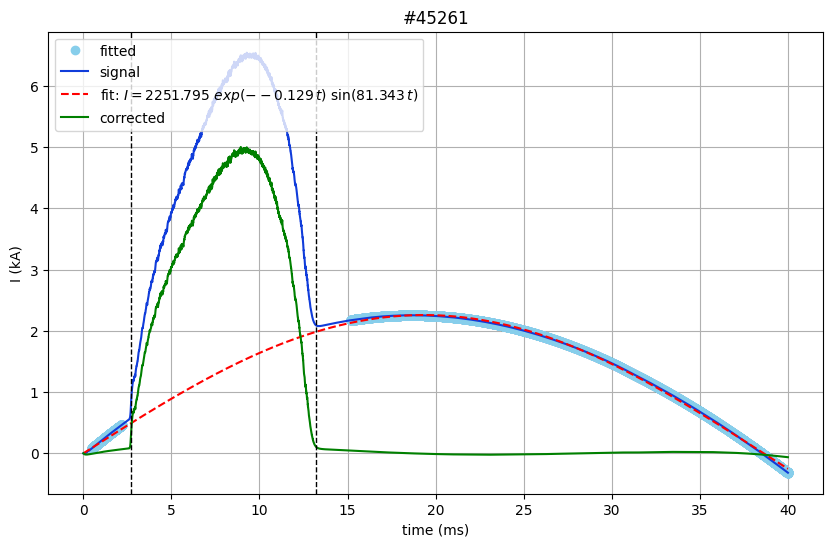

C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\175531659.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_start = float(t_start.to_numpy())
C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\175531659.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_end = float(t_end.to_numpy())


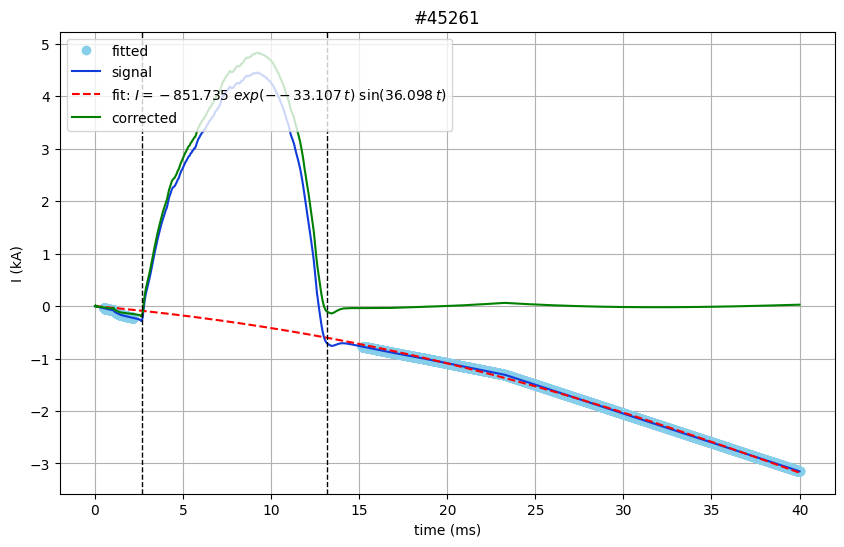

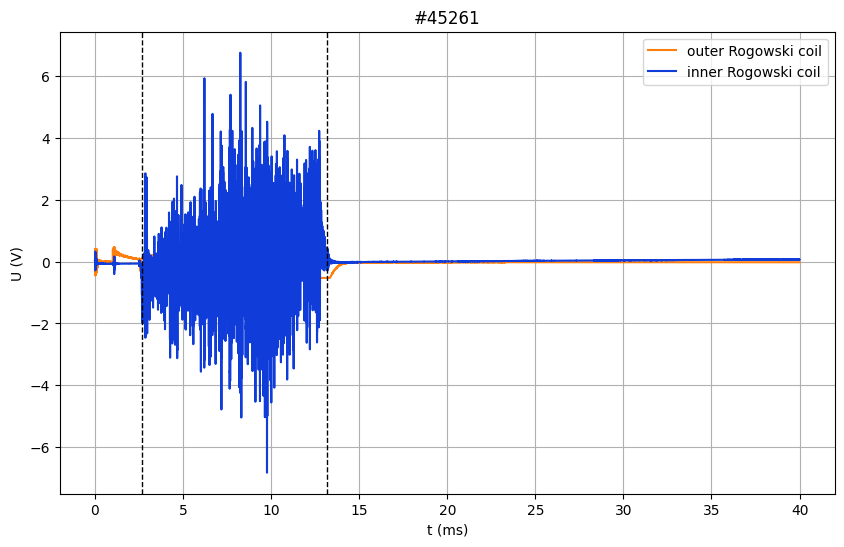

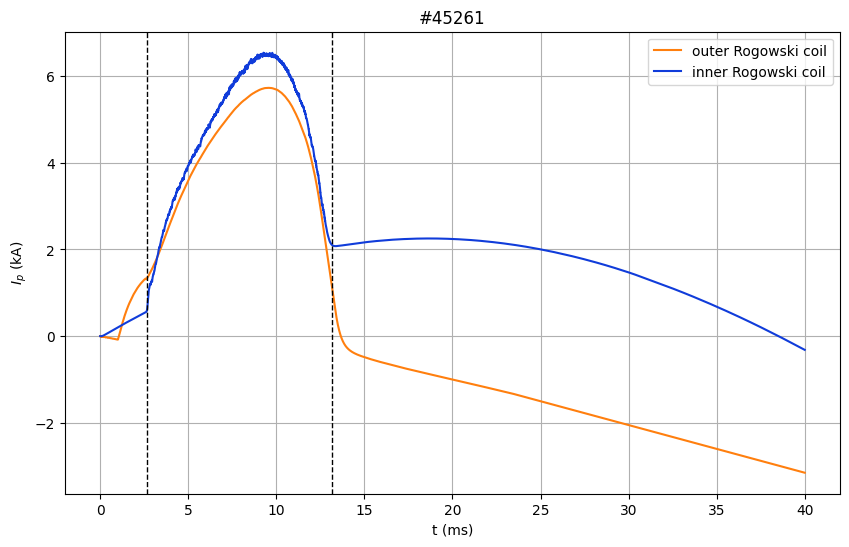

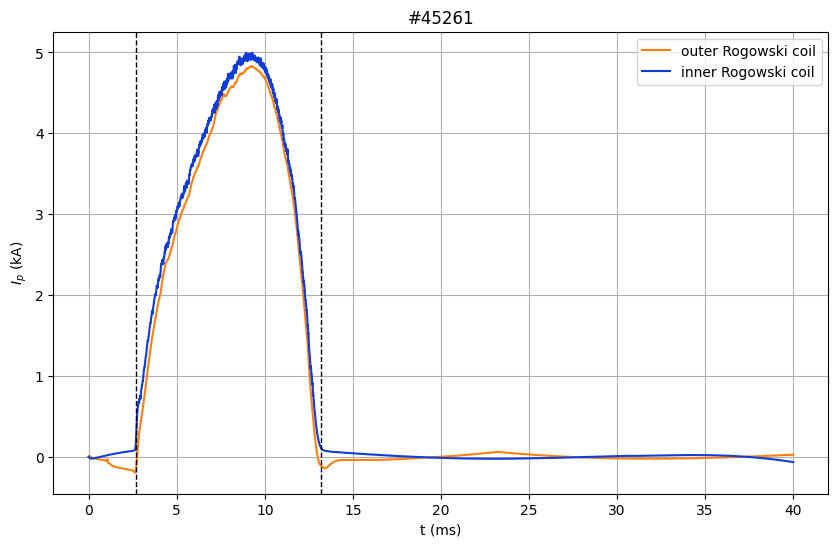

End of Rogowski coil analysis



C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\2029335351.py:35: SuspiciousDataWarning: No negative-time (pre-trigger) data available for offset computation. Using first 100 samples instead.
  raw_data_detrended_vacuum = remove_offset(data=raw_data_checked_vacuum)
C:\Users\tomas\AppData\Local\Temp\ipykernel_14848\2029335351.py:36: SuspiciousDataWarning: No negative-time (pre-trigger) data available for offset computation. Using first 100 samples instead.
  raw_data_detrended = remove_offset(data=raw_data_checked)


Compensation of magnetic flux...
calibration number m: 0.7688257892071063, intercept: 0.003403700553588851
Magnetic flux computation...
Energy and confinement time computation...
Plotting...


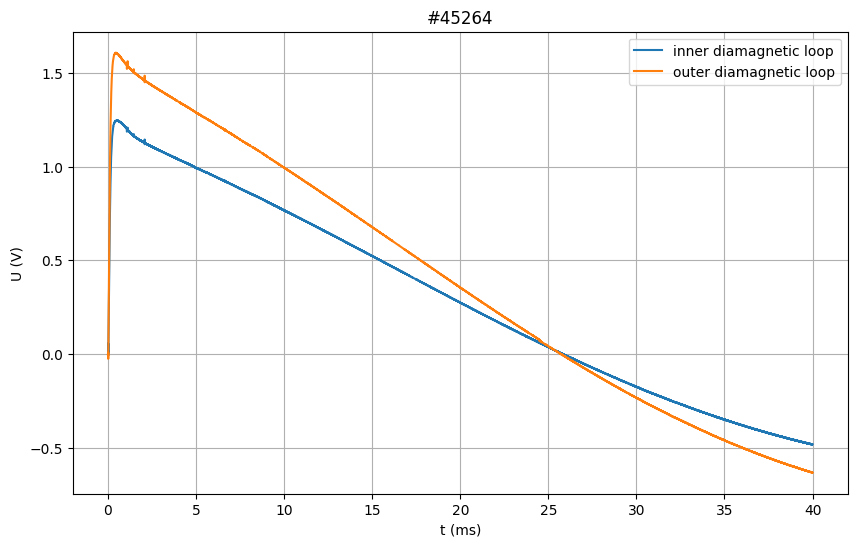

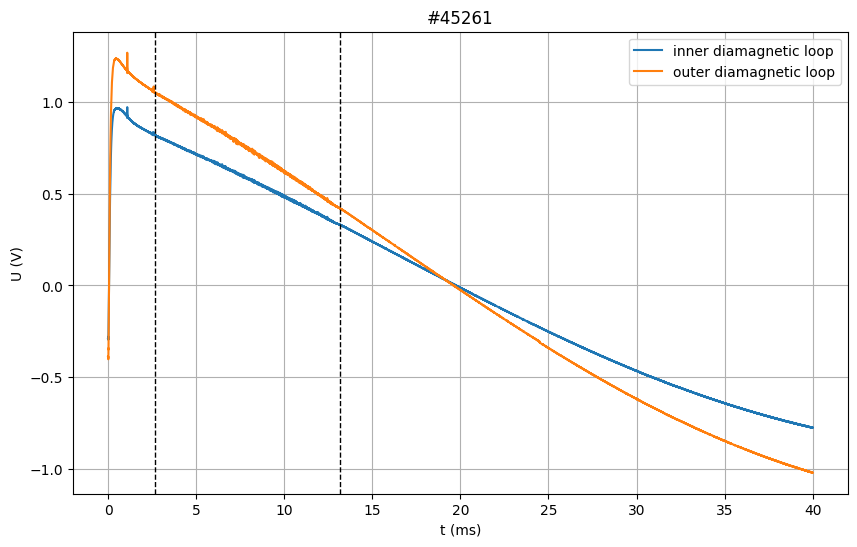

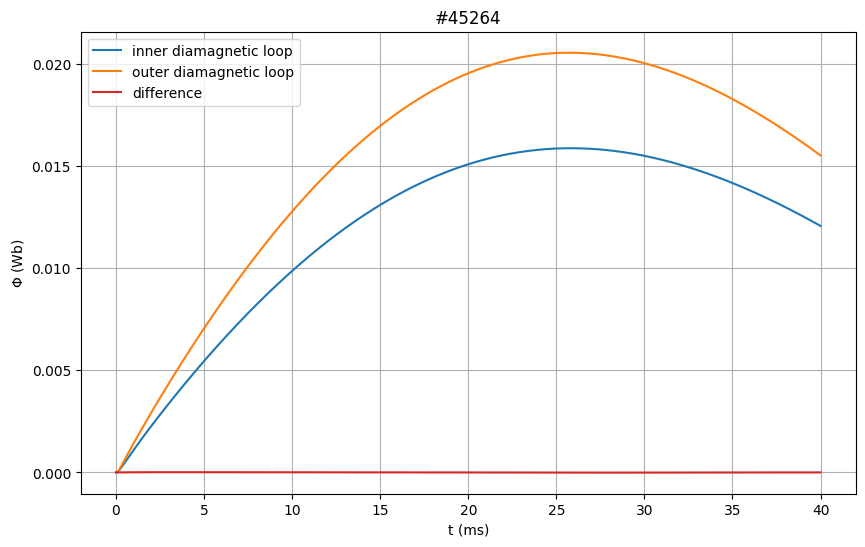

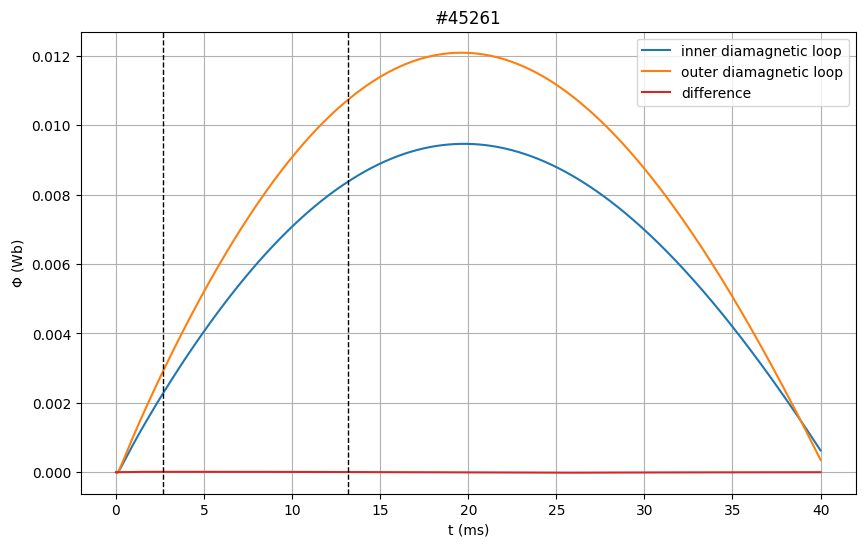

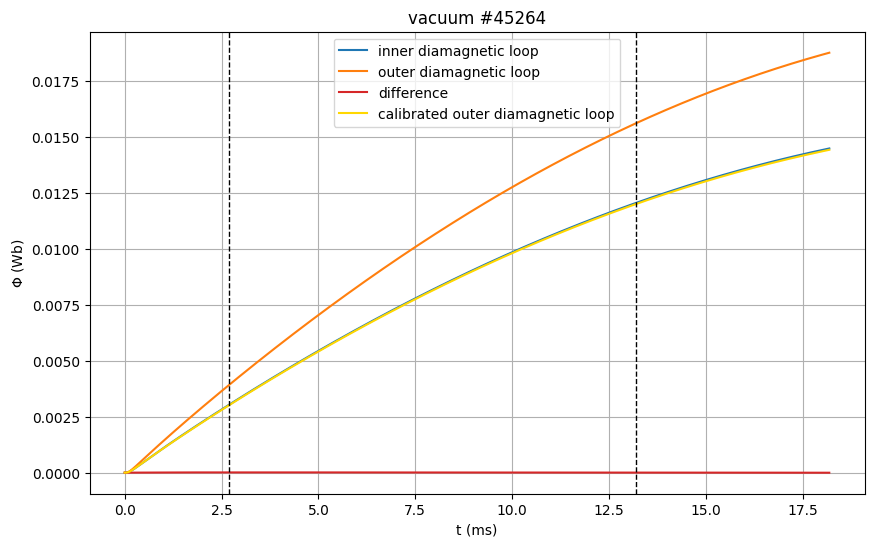

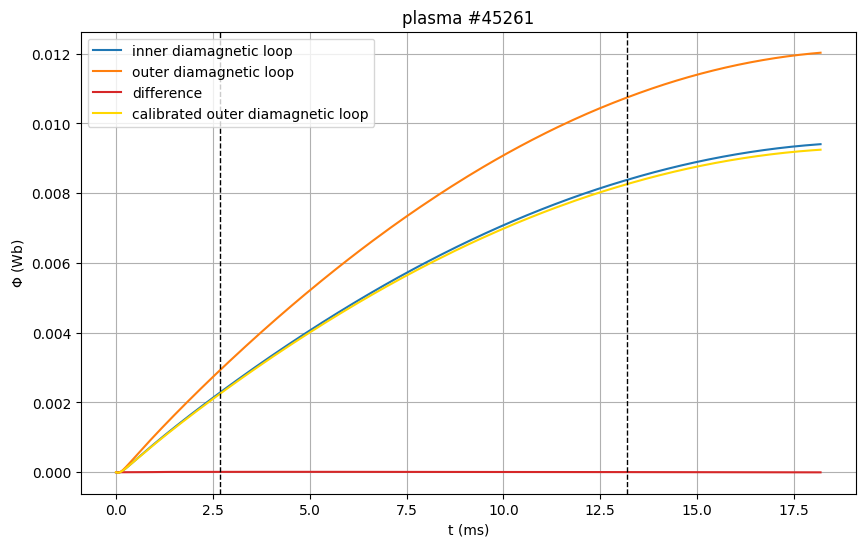

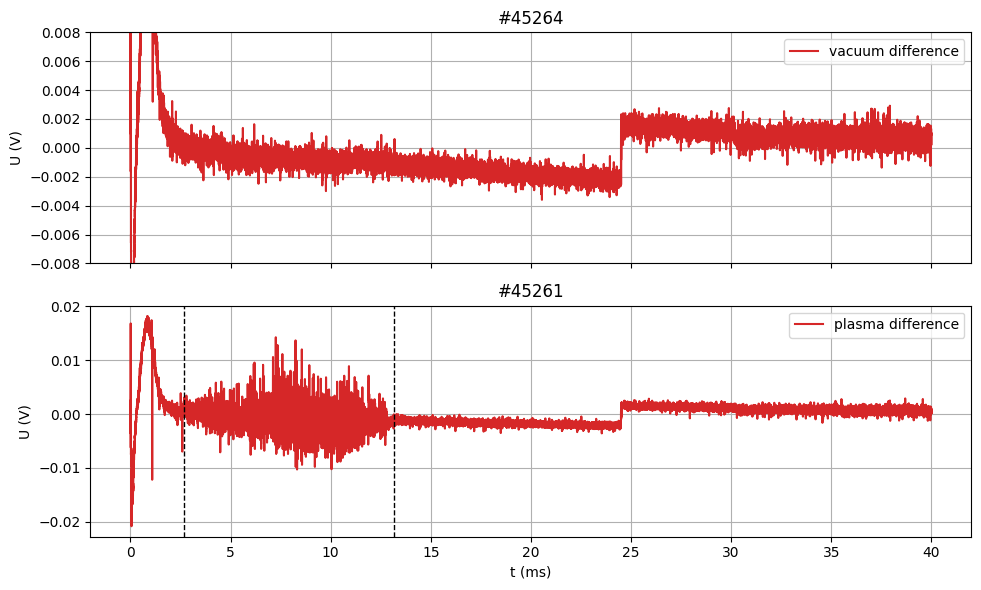

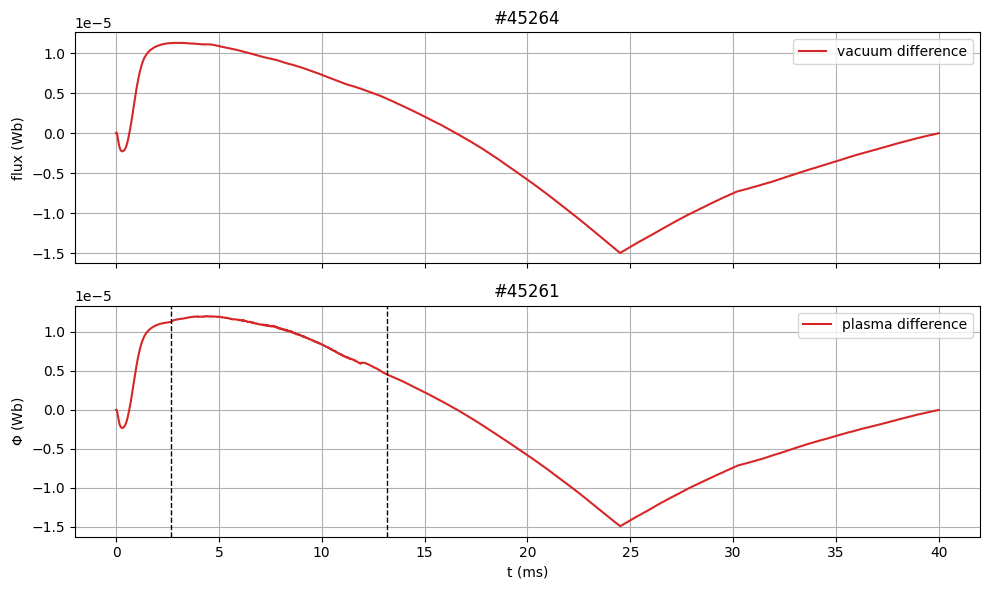

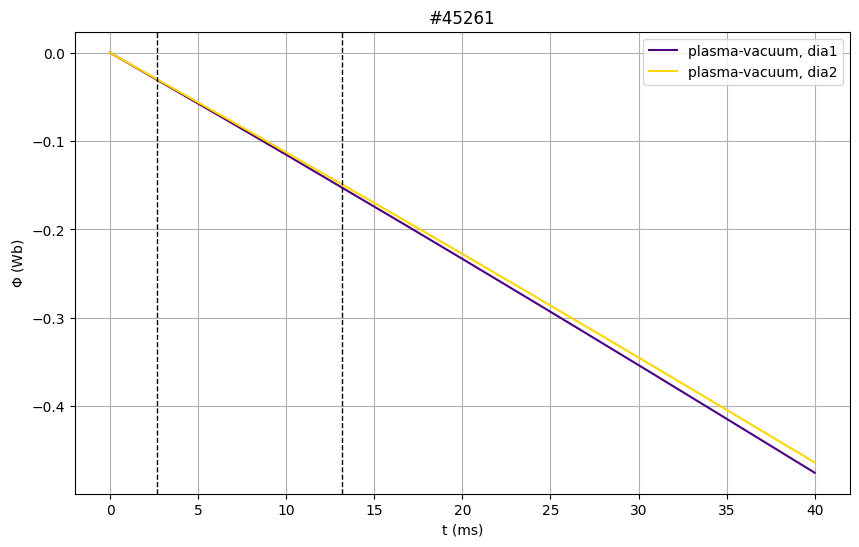

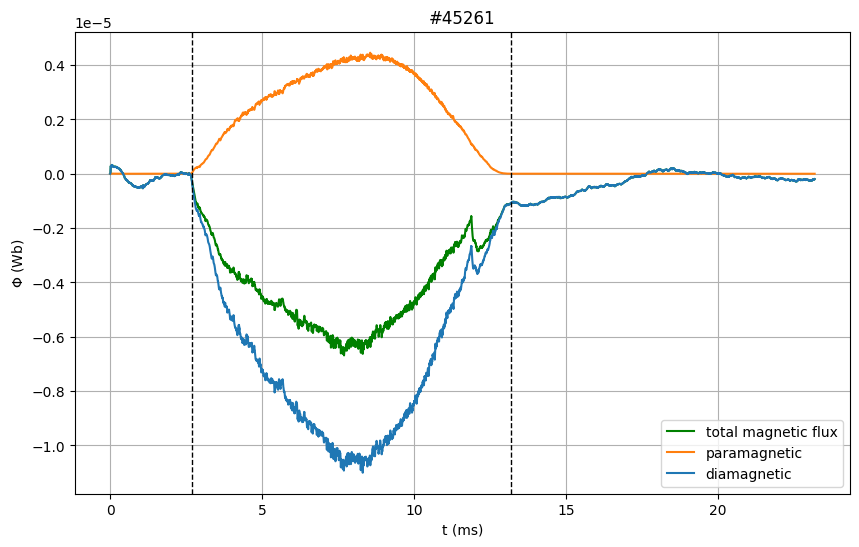

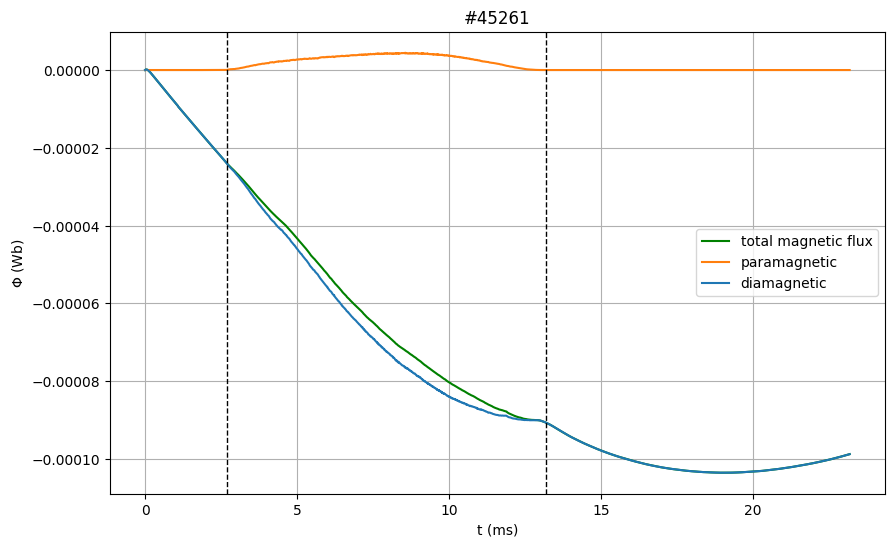

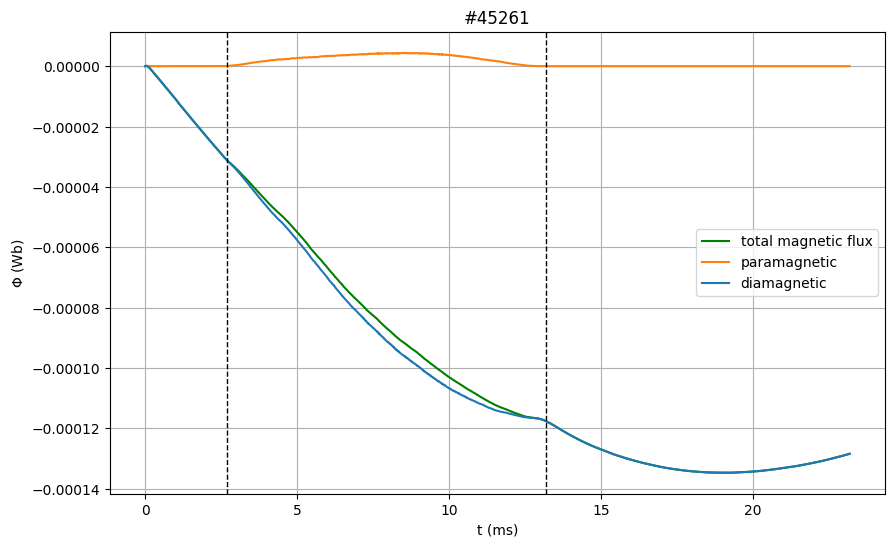

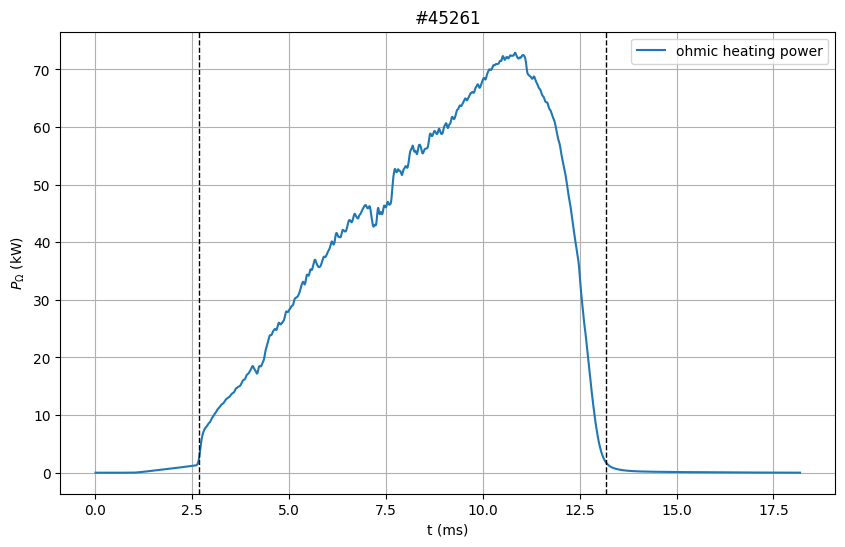

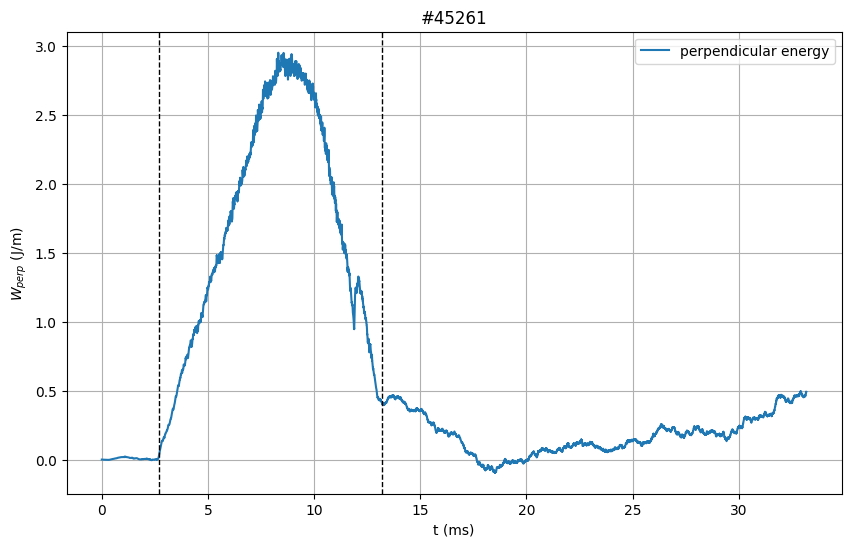

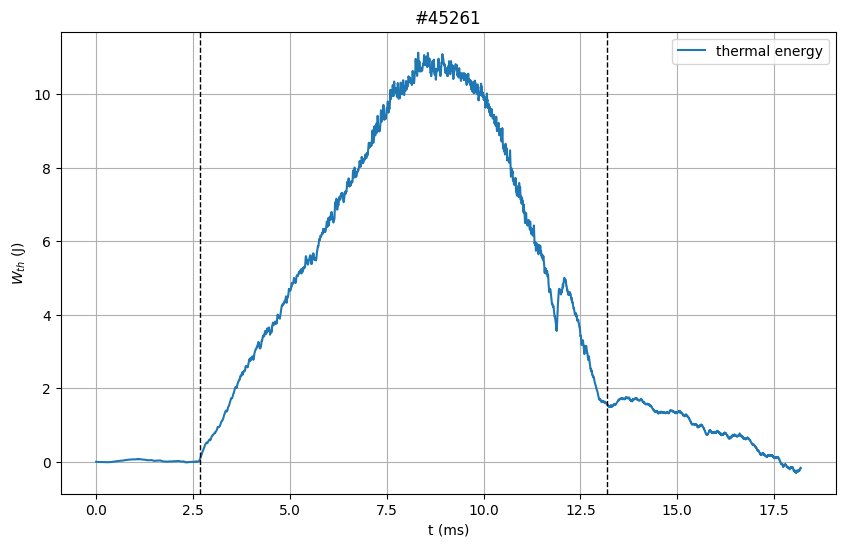

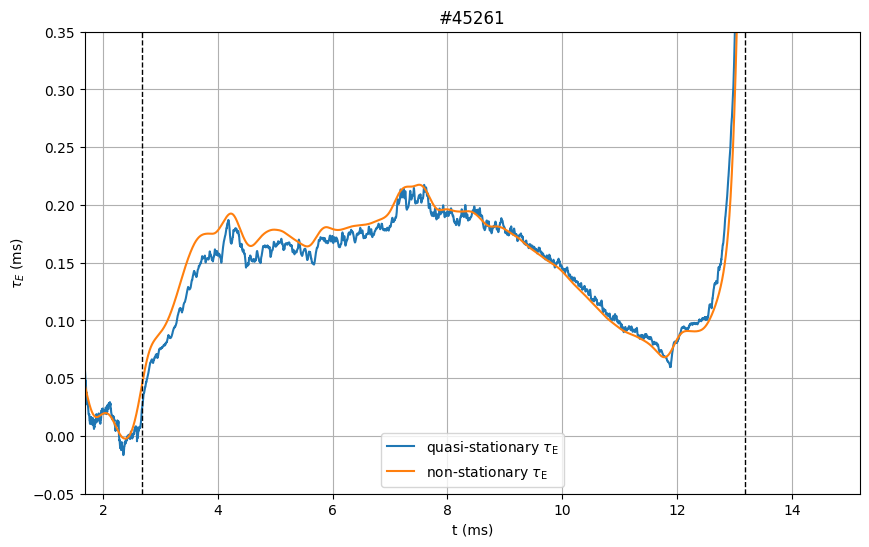

End of diamagnetism analysis...



In [35]:
# diamagnetic loops parameters
D_1 = 17.5 # diameter of inner diamagnetic loop in cm
D_2 = 20.4 # diameter of outer diamagnetic loop in cm
# conversion to m
D_1 *= 1e-2
D_2 *= 1e-2

# effective surface of loop
A_1 = np.pi * D_1**2 / 4
A_2 = np.pi * D_2**2 / 4

print('...DIAMAGNETISM ANALYSIS...')
print('Loading data...')
# load parameters
t_start, t_end = get_plasma_time_parameters(shot_no=shot_no)

# load raw data
raw_data_vacuum = get_diamagnet_data(shot_no=shot_no_vacuum)
raw_data = get_diamagnet_data(shot_no=shot_no)

U_loop = get_U_loop_data(shot_no=shot_no)

# load integrated data
I_p, _ = rogowski_coil_analysis(shot_no=shot_no, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)
# Bt = Bt_TFC.copy()
Bt = get_Bt_data(shot_no=shot_no)

# check if data are non-physical
raw_data_checked_vacuum = check_broken_data(data=raw_data_vacuum, name='raw_data_vacuum')
raw_data_checked = check_broken_data(data=raw_data, name='raw_data')

U_loop_checked = check_broken_data(data=U_loop, name='U_loop')

# remove offset from raw signal
raw_data_detrended_vacuum = remove_offset(data=raw_data_checked_vacuum)
raw_data_detrended = remove_offset(data=raw_data_checked)

U_loop_detrended = remove_offset(data=U_loop_checked)

# repair broken (non-finite) data points for safe integration
raw_data_repaired_vacuum = repair_broken_data(data=raw_data_detrended_vacuum, name='raw_data_detrended_vacuum')
raw_data_repaired = repair_broken_data(data=raw_data_detrended, name='raw_data_detrended')

U_loop_repaired = repair_broken_data(data=U_loop_detrended, name='U_loop_detrended')

# make sure that raw_data and raw_data_vacuum are same length (sometimes not true)
new_raw_data_repaired_vacuum = raw_data_repaired.copy()
for col in [c for c in raw_data_repaired_vacuum.columns if c != 't']:
    new_raw_data_repaired_vacuum[col] = np.interp(raw_data['t'], raw_data_vacuum['t'], raw_data_vacuum[col])
raw_data_repaired_vacuum = new_raw_data_repaired_vacuum

# compensation of magnetic flux with diamagnetic loops
print('Compensation of magnetic flux...')
raw_data_compensated_vacuum, raw_data_compensated, m, intercept = magnetic_flux_compensation(shot_no_vacuum=shot_no_vacuum, shot_no=shot_no, raw_data_vacuum=raw_data_repaired_vacuum, raw_data=raw_data_repaired, method='m constant')

# compute total magnetic flux
print('Magnetic flux computation...')
magnetic_flux_vacuum, magnetic_flux = compute_magnetic_flux(raw_data_vacuum=raw_data_compensated_vacuum, raw_data=raw_data_compensated, A_1=A_1, A_2=A_2)

# compute paramagnetic and diamagnetic effects
magnetic_flux, I_p, B_0 = compute_magnetic_flux_contributions(magnetic_flux=magnetic_flux, I_all=I_p, Bt=Bt, method='rogowski1')

# compute perp. energy, thermal energy and energy confinement time
print('Energy and confinement time computation...')
P_ohm, W_perp, W_th, tau_E = compute_W_and_tau(magnetic_flux=magnetic_flux, U_loop=U_loop_repaired, I_p=I_p, B_0=B_0, R=R_Gt)

print('Plotting...')
# plot raw signal
plot_raw_data(shot_no_vacuum=shot_no_vacuum, shot_no=shot_no, raw_data_vacuum=raw_data_repaired_vacuum, raw_data=raw_data_repaired, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

# plot integrated data
plot_integrated_data(shot_no_vacuum=shot_no_vacuum, shot_no=shot_no, integrated_data_vacuum=magnetic_flux_vacuum, integrated_data=magnetic_flux, calibration_const=m, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

# plot difference signal
plot_difference_signal(shot_no_vacuum=shot_no_vacuum, shot_no=shot_no, raw_data_vacuum=raw_data_compensated_vacuum, raw_data=raw_data_compensated, integrated_data_vacuum=magnetic_flux_vacuum, integrated_data=magnetic_flux, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

# plot magnetic flux change
plot_magnetic_flux(shot_no=shot_no, magnetic_flux_vacuum=magnetic_flux_vacuum, magnetic_flux=magnetic_flux, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

# plot total toroidal magnetic flux, paramagnetic and diamagnetic toroidal magnetic flux
plot_magnetic_flux_contributions(shot_no=shot_no, magnetic_flux=magnetic_flux, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

# plot ohmic heating power
plot_P_ohm(shot_no=shot_no, P_ohm=P_ohm, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

# plot perp. energy
plot_W_perp(shot_no=shot_no, W_perp=W_perp, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

# plot thermal energy
plot_W_th(shot_no=shot_no, W_th=W_th, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

# plot energy confinement time
plot_tau_E(shot_no=shot_no, tau_E=tau_E, showFig=showFig, saveFig=saveFig, saveFormat=saveFormat)

print('End of diamagnetism analysis...'); print('')